# Phase 1 — Exposure Landscape
This notebook implements the Phase‑1 exposure analysis (occupation + industry), using `srvy_wght_tru2` as the primary weight. All outputs are exported under `Results Datasets/analysis/phase1/`.

## Setup + Phase 1 summary

In [396]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Paths
def find_root():
    if "__file__" in globals():
        return Path(__file__).resolve().parents[2]
    cwd = Path.cwd().resolve()
    for p in [cwd] + list(cwd.parents):
        if (p / "Results Datasets" / "final_analysis_dataset.parquet").exists():
            return p
    return cwd
ROOT = find_root()
DATA_PATH = ROOT / "Results Datasets" / "final_analysis_dataset.parquet"
OUT_ROOT = ROOT / "Results Datasets" / "analysis" / "phase1"
OUT_TABLES = OUT_ROOT / "tables"
OUT_VIS = OUT_ROOT / "visuals"
for d in [OUT_ROOT, OUT_TABLES, OUT_VIS]:
    d.mkdir(parents=True, exist_ok=True)

# --- Load data
if not DATA_PATH.exists():
    raise FileNotFoundError(DATA_PATH)

cols = None  # load all
_df = pd.read_parquet(DATA_PATH)
# Year filter
_df = _df[(_df["adve_time_year"] >= 2010) & (_df["adve_time_year"] <= 2024)].copy()

# Core columns
occ_exp_col = "occupation_exposure"
ind_exp_col = "industry_exposure_weighted"
occ_raw_col = "occu_isco_2008"  # raw ISCO
noga_col = "comp_indu_noga"

# Ensure numeric exposure
for col in [occ_exp_col, ind_exp_col]:
    _df[col] = pd.to_numeric(_df[col], errors="coerce")

# --- Labels (cross‑walks)
def weighted_quantile(values, weights, q):
    vals = values.to_numpy(dtype=float)
    wts = weights.to_numpy(dtype=float)
    mask = ~np.isnan(vals) & ~np.isnan(wts)
    if mask.sum() == 0:
        return np.nan
    vals = vals[mask]
    wts = wts[mask]
    order = np.argsort(vals)
    vals = vals[order]
    wts = wts[order]
    cum = np.cumsum(wts)
    total = cum[-1]
    return vals[np.searchsorted(cum, q * total)]

CW_DIR = ROOT / "External datasets" / "Cross-walks"

# NOGA labels
noga_map = {}
path_noga = CW_DIR / "comp_indu_noga_to_noga2digit_expanded.csv"
if path_noga.exists():
    noga = pd.read_csv(path_noga)
    noga["comp_indu_noga"] = pd.to_numeric(noga["comp_indu_noga"], errors="coerce")
    noga_map = (
        noga.dropna(subset=["comp_indu_noga"])
        .drop_duplicates(subset=["comp_indu_noga"])
        .set_index("comp_indu_noga")["label_de"].to_dict()
    )

# ISCO labels
isco1_map = {}
isco2_map = {}
path_isco1 = CW_DIR / "isco_major_code_to_label.csv"
path_isco2 = CW_DIR / "isco_08_submajor_2digit_code_to_label.csv"
if path_isco1.exists():
    t = pd.read_csv(path_isco1)
    t["isco_major"] = pd.to_numeric(t["isco_major"], errors="coerce")
    isco1_map = t.set_index("isco_major")["label_en"].to_dict()
if path_isco2.exists():
    t = pd.read_csv(path_isco2)
    t["isco_08_submajor_2d"] = pd.to_numeric(t["isco_08_submajor_2d"], errors="coerce")
    isco2_map = t.set_index("isco_08_submajor_2d")["label_en"].to_dict()

# Build raw ISCO string
isco_raw_str = _df[occ_raw_col].astype("string").str.split(".").str[0]
isco_raw_str = isco_raw_str.str.replace(r"[^0-9]", "", regex=True)
# zero-fill to 4 digits if numeric and length < 4
isco_raw_str = isco_raw_str.apply(lambda x: x.zfill(4) if x is not pd.NA and str(x).isdigit() and len(str(x)) < 4 else x)

major_placeholders = {"1000","2000","3000","4000","5000","6000","7000","8000","9000"}
isco_is_major_placeholder = isco_raw_str.isin(major_placeholders)

# Labels (do not add permanent new code columns to dataset; just build series)
isco1_label = isco_raw_str.str[:1].apply(lambda x: isco1_map.get(int(x)) if str(x).isdigit() else pd.NA)
isco2_label = isco_raw_str.apply(
    lambda x: "Unknown sub-major (major group only)" if x in major_placeholders else (
        isco2_map.get(int(str(x)[:2])) if str(x)[:2].isdigit() else pd.NA
    )
)

if "comp_indu_noga_label" in _df.columns and _df["comp_indu_noga_label"].notna().any():
    _df["comp_indu_noga_label"] = _df["comp_indu_noga_label"].astype("string")
elif noga_map:
    _df["comp_indu_noga_label"] = pd.to_numeric(_df[noga_col], errors="coerce").map(noga_map).astype("string")
else:
    _df["comp_indu_noga_label"] = pd.NA
_df["occu_isco1_label"] = isco1_label.astype("string")
_df["occu_isco2_label"] = isco2_label.astype("string")
_df["isco_is_major_placeholder"] = isco_is_major_placeholder

# Diagnostic table for placeholders
placeholder_counts = (
    pd.DataFrame({"isco_raw": isco_raw_str, "is_placeholder": isco_is_major_placeholder})
    .loc[isco_is_major_placeholder, "isco_raw"]
    .value_counts()
    .rename_axis("isco_raw")
    .reset_index(name="count")
)
placeholder_diag = pd.DataFrame({
    "total_rows": [len(_df)],
    "placeholder_rows": [isco_is_major_placeholder.sum()],
    "placeholder_share": [isco_is_major_placeholder.mean()],
})
placeholder_diag.to_csv(OUT_TABLES / "table_isco_placeholder_diagnostic.csv", index=False)

# Region labels (Unknown kept)
special_codes = {"-3","-7","-8","-9"}

canton_map = {
    1:"ZH",2:"BE",3:"LU",4:"UR",5:"SZ",6:"OW",7:"NW",8:"GL",9:"ZG",
    10:"FR",11:"SO",12:"BS",13:"BL",14:"SH",15:"AR",16:"AI",17:"SG",
    18:"GR",19:"AG",20:"TG",21:"TI",22:"VD",23:"VS",24:"NE",25:"GE",26:"JU"
}

def label_region(series, is_canton=False):
    raw = series.astype("string")
    lab = raw.where(~raw.isin(special_codes), other="Unknown")
    lab = lab.fillna("Unknown")
    if is_canton:
        def map_canton(val):
            if val == "Unknown" or pd.isna(val):
                return "Unknown"
            return canton_map.get(int(val), val) if str(val).isdigit() else val
        lab = lab.apply(map_canton)
    return lab.astype("string")

_df["loca_regi_kant_label"] = label_region(_df["loca_regi_kant"], is_canton=True)
_df["loca_regi_nuts_label"] = label_region(_df["loca_regi_nuts"], is_canton=False)

# Thresholds (global, unweighted)
# Unweighted thresholds (reference only)
occ_p80_unw, occ_p90_unw = _df[occ_exp_col].quantile([0.8,0.9]).values
ind_p80_unw, ind_p90_unw = _df[ind_exp_col].quantile([0.8,0.9]).values
# Weighted thresholds (tru2) used in all analysis
occ_p80 = weighted_quantile(_df[occ_exp_col], _df["srvy_wght_tru2"], 0.80)
occ_p90 = weighted_quantile(_df[occ_exp_col], _df["srvy_wght_tru2"], 0.90)
ind_p80 = weighted_quantile(_df[ind_exp_col], _df["srvy_wght_tru2"], 0.80)
ind_p90 = weighted_quantile(_df[ind_exp_col], _df["srvy_wght_tru2"], 0.90)
occ_p20 = weighted_quantile(_df[occ_exp_col], _df["srvy_wght_tru2"], 0.20)
occ_p40 = weighted_quantile(_df[occ_exp_col], _df["srvy_wght_tru2"], 0.40)
occ_p60 = weighted_quantile(_df[occ_exp_col], _df["srvy_wght_tru2"], 0.60)
ind_p20 = weighted_quantile(_df[ind_exp_col], _df["srvy_wght_tru2"], 0.20)
ind_p40 = weighted_quantile(_df[ind_exp_col], _df["srvy_wght_tru2"], 0.40)
ind_p60 = weighted_quantile(_df[ind_exp_col], _df["srvy_wght_tru2"], 0.60)
occ_p20, occ_p40, occ_p60 = _df[occ_exp_col].quantile([0.2,0.4,0.6]).values
ind_p20, ind_p40, ind_p60 = _df[ind_exp_col].quantile([0.2,0.4,0.6]).values

# Coverage (tru2-weighted)
tru2_total = _df["srvy_wght_tru2"].sum()
occ_cov_tru2 = _df.loc[_df[occ_exp_col].notna(), "srvy_wght_tru2"].sum() / tru2_total
ind_cov_tru2 = _df.loc[_df[ind_exp_col].notna(), "srvy_wght_tru2"].sum() / tru2_total

# Unknown region share (tru2)
unknown_kant_share = _df.loc[_df["loca_regi_kant_label"] == "Unknown", "srvy_wght_tru2"].sum() / tru2_total
unknown_nuts_share = _df.loc[_df["loca_regi_nuts_label"] == "Unknown", "srvy_wght_tru2"].sum() / tru2_total

summary = {
    "thresholds": {
        "occ_p80": float(occ_p80), "occ_p90": float(occ_p90),
        "ind_p80": float(ind_p80), "ind_p90": float(ind_p90),
    },
    "coverage_tru2": {"occ": float(occ_cov_tru2), "ind": float(ind_cov_tru2)},
    "unknown_region_share_tru2": {"kanton": float(unknown_kant_share), "nuts": float(unknown_nuts_share)},
    "scatter_label_strategy": "labels = top 10 by demand + top 10 by mean exposure + top 10 by exposed demand (+ optional lowest exposure); deduplicated",
}

(OUT_ROOT / "phase1_summary.json").write_text(json.dumps(summary, indent=2))
summary


{'thresholds': {'occ_p80': 1.2196835,
  'occ_p90': 1.277449425,
  'ind_p80': 0.9475425749999999,
  'ind_p90': 1.3283719699999998},
 'coverage_tru2': {'occ': 0.9183896392364413, 'ind': 0.9489883855451481},
 'unknown_region_share_tru2': {'kanton': 0.060835489601052714,
  'nuts': 0.060835489601052714},
 'scatter_label_strategy': 'labels = top 10 by demand + top 10 by mean exposure + top 10 by exposed demand (+ optional lowest exposure); deduplicated'}

## 3) Exposure distributions (CDFs)

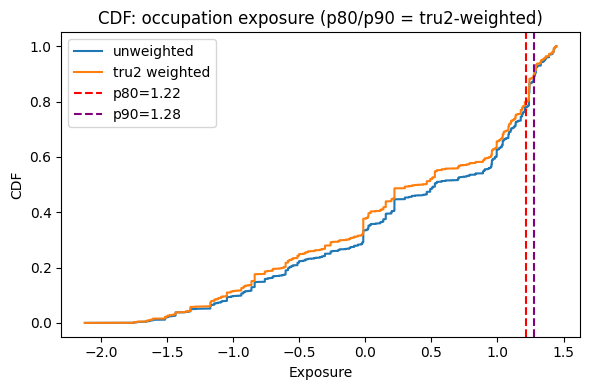

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_cdf_occ.png


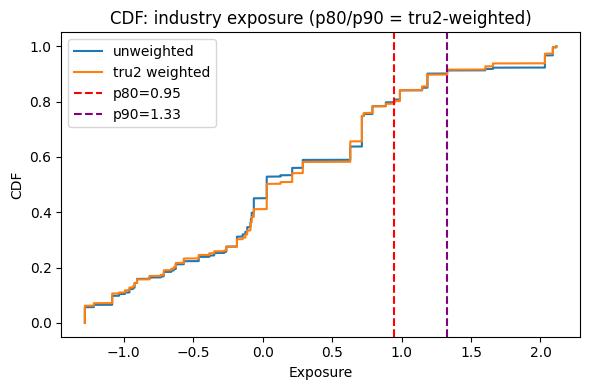

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_cdf_ind.png


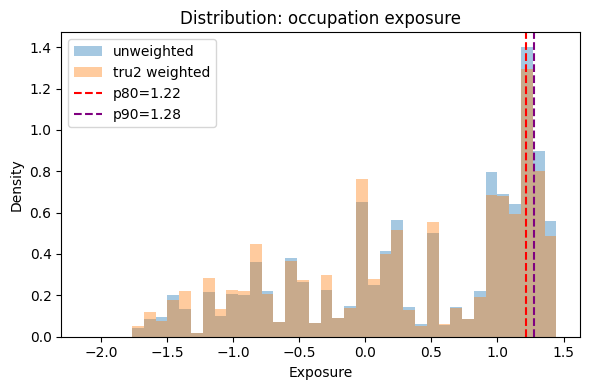

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_pdf_occ.png


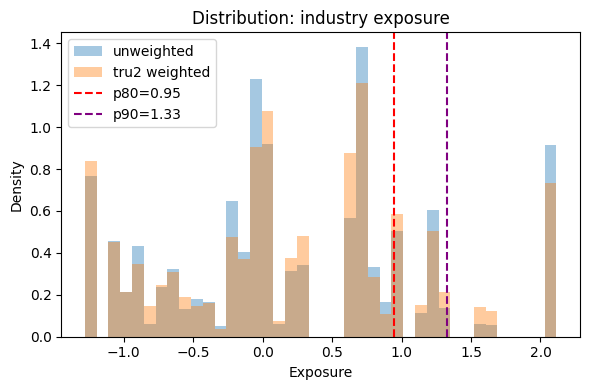

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_pdf_ind.png


In [397]:
def plot_cdf(series, weights=None, label="weighted", ax=None):
    s = series.dropna().to_numpy()
    if weights is None:
        w = np.ones_like(s)
    else:
        w = weights.loc[series.dropna().index].to_numpy()
    order = np.argsort(s)
    s_sorted = s[order]
    w_sorted = w[order]
    cum = np.cumsum(w_sorted)
    cum = cum / cum[-1]
    ax.plot(s_sorted, cum, label=label)

# Occupation CDF
fig, ax = plt.subplots(figsize=(6,4))
plot_cdf(_df[occ_exp_col], None, label="unweighted", ax=ax)
plot_cdf(_df[occ_exp_col], _df["srvy_wght_tru2"], label="tru2 weighted", ax=ax)
ax.axvline(occ_p80, color='red', linestyle='--', label=f'p80={occ_p80:.2f}')
ax.axvline(occ_p90, color='purple', linestyle='--', label=f'p90={occ_p90:.2f}')
ax.set_title("CDF: occupation exposure (p80/p90 = tru2‑weighted)")
ax.set_xlabel("Exposure")
ax.set_ylabel("CDF")
ax.legend()
plt.tight_layout()
fig_path = OUT_VIS / "fig_cdf_occ.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Industry CDF
fig, ax = plt.subplots(figsize=(6,4))
plot_cdf(_df[ind_exp_col], None, label="unweighted", ax=ax)
plot_cdf(_df[ind_exp_col], _df["srvy_wght_tru2"], label="tru2 weighted", ax=ax)
ax.axvline(ind_p80, color='red', linestyle='--', label=f'p80={ind_p80:.2f}')
ax.axvline(ind_p90, color='purple', linestyle='--', label=f'p90={ind_p90:.2f}')
ax.set_title("CDF: industry exposure (p80/p90 = tru2‑weighted)")
ax.set_xlabel("Exposure")
ax.set_ylabel("CDF")
ax.legend()
plt.tight_layout()
fig_path = OUT_VIS / "fig_cdf_ind.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


# Occupation distribution (non-cumulative)
fig, ax = plt.subplots(figsize=(6,4))
occ_s = _df[occ_exp_col].dropna()
occ_w = _df.loc[occ_s.index, "srvy_wght_tru2"]
bins = 40
ax.hist(occ_s, bins=bins, density=True, alpha=0.4, label="unweighted")
ax.hist(occ_s, bins=bins, density=True, weights=occ_w, alpha=0.4, label="tru2 weighted")
ax.axvline(occ_p80, color='red', linestyle='--', label=f'p80={occ_p80:.2f}')
ax.axvline(occ_p90, color='purple', linestyle='--', label=f'p90={occ_p90:.2f}')
ax.set_title("Distribution: occupation exposure")
ax.set_xlabel("Exposure")
ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()
fig_path = OUT_VIS / "fig_pdf_occ.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Industry distribution (non-cumulative)
fig, ax = plt.subplots(figsize=(6,4))
ind_s = _df[ind_exp_col].dropna()
ind_w = _df.loc[ind_s.index, "srvy_wght_tru2"]
ax.hist(ind_s, bins=bins, density=True, alpha=0.4, label="unweighted")
ax.hist(ind_s, bins=bins, density=True, weights=ind_w, alpha=0.4, label="tru2 weighted")
ax.axvline(ind_p80, color='red', linestyle='--', label=f'p80={ind_p80:.2f}')
ax.axvline(ind_p90, color='purple', linestyle='--', label=f'p90={ind_p90:.2f}')
ax.set_title("Distribution: industry exposure")
ax.set_xlabel("Exposure")
ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()
fig_path = OUT_VIS / "fig_pdf_ind.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


## 4) Concentration: Top‑X curve + summary

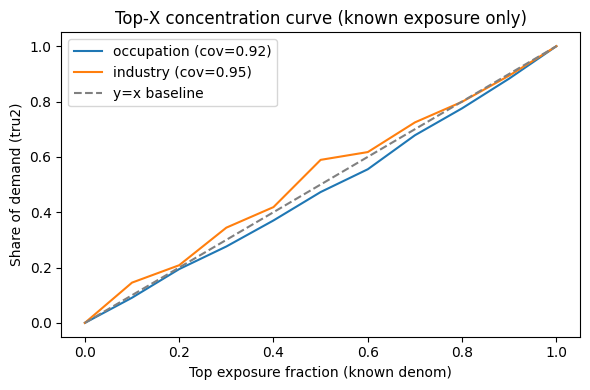

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_topx_known_denom.png


,top_fraction,occ_share,ind_share
0,0.0,0.000000,0.000000
1,0.1,0.090915,0.145514
2,0.2,0.194322,0.208364
3,0.3,0.276060,0.344134
4,0.4,0.370185,0.418411
5,0.5,0.472856,0.589156
6,0.6,0.555198,0.617293
7,0.7,0.678099,0.724606
8,0.8,0.775447,0.799009
9,0.9,0.883051,0.893890


In [398]:
def demand_share_at_threshold(col, thresh, weight_col):
    mask = _df[col] >= thresh
    return _df.loc[mask, weight_col].sum() / _df[weight_col].sum()

rows = []
for col, label in [(occ_exp_col, "occupation"), (ind_exp_col, "industry")]:
    p80, p90 = _df[col].quantile([0.8,0.9]).values
    row = {"measure": label}
    row["p80"] = p80
    row["p90"] = p90
    row["coverage_tru2"] = _df.loc[_df[col].notna(), "srvy_wght_tru2"].sum() / _df["srvy_wght_tru2"].sum()
    # tru2
    row["share_top10_tru2"] = demand_share_at_threshold(col, p90, "srvy_wght_tru2")
    row["share_top20_tru2"] = demand_share_at_threshold(col, p80, "srvy_wght_tru2")
    row["share_top50_tru2"] = demand_share_at_threshold(col, _df[col].quantile(0.5), "srvy_wght_tru2")
    row["share_bottom10_tru2"] = _df.loc[_df[col] <= _df[col].quantile(0.1), "srvy_wght_tru2"].sum() / _df["srvy_wght_tru2"].sum()
    # tru1 check
    row["share_top10_tru1"] = demand_share_at_threshold(col, p90, "srvy_wght_tru1")
    row["share_top20_tru1"] = demand_share_at_threshold(col, p80, "srvy_wght_tru1")
    row["share_top50_tru1"] = demand_share_at_threshold(col, _df[col].quantile(0.5), "srvy_wght_tru1")
    row["share_bottom10_tru1"] = _df.loc[_df[col] <= _df[col].quantile(0.1), "srvy_wght_tru1"].sum() / _df["srvy_wght_tru1"].sum()
    rows.append(row)

concentration_tbl = pd.DataFrame(rows)
concentration_tbl.to_csv(OUT_TABLES / "table_concentration_summary.csv", index=False)
concentration_tbl

# Known-denom Top-X curve
occ_nonmiss = _df[_df[occ_exp_col].notna()].copy()
ind_nonmiss = _df[_df[ind_exp_col].notna()].copy()
occ_total = occ_nonmiss['srvy_wght_tru2'].sum()
ind_total = ind_nonmiss['srvy_wght_tru2'].sum()
xs = np.linspace(0, 1, 11)

def topx_share_nonmiss(sub_df, col, frac):
    if frac <= 0:
        return 0.0
    s = pd.to_numeric(sub_df[col], errors='coerce').to_numpy(dtype=float)
    w = sub_df['srvy_wght_tru2'].to_numpy(dtype=float)
    valid = ~np.isnan(s)
    s = s[valid]
    w = w[valid]
    if len(s) == 0:
        return np.nan
    cutoff = np.nanquantile(s, 1 - frac)
    mask = s >= cutoff
    return w[mask].sum() / w.sum()

rows = []
for x in xs:
    rows.append({
        'top_fraction': x,
        'occ_share': topx_share_nonmiss(occ_nonmiss, occ_exp_col, x),
        'ind_share': topx_share_nonmiss(ind_nonmiss, ind_exp_col, x),
    })
conc_curve = pd.DataFrame(rows)

cov_occ = occ_total / _df['srvy_wght_tru2'].sum()
cov_ind = ind_total / _df['srvy_wght_tru2'].sum()

plt.figure(figsize=(6,4))
plt.plot(conc_curve['top_fraction'], conc_curve['occ_share'], label=f'occupation (cov={cov_occ:.2f})')
plt.plot(conc_curve['top_fraction'], conc_curve['ind_share'], label=f'industry (cov={cov_ind:.2f})')
plt.plot(conc_curve['top_fraction'], conc_curve['top_fraction'], linestyle='--', color='gray', label='y=x baseline')
plt.xlabel('Top exposure fraction (known denom)')
plt.ylabel('Share of demand (tru2)')
plt.title('Top‑X concentration curve (known exposure only)')
plt.legend()
plt.tight_layout()
fig_path = OUT_VIS / "fig_topx_known_denom.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)
conc_curve


## 5) Impact zones — Occupations (ISCO 1, 2, and 4‑digit)


Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_occ1_full.csv


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/4265202061.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  occ1_metrics["mean_occ_exp_tru2"] = occ1_group.apply(lambda g: wmean(g, occ_exp_col)).values


,occ1_code,occ1_label,demand_total_tru2,postings_total_tru1,n_ads,mean_occ_exp_tru2
1,1,Managers,91537.2124,90578.3302,4097,1.027624
4,4,Clerical support workers,176291.7494,162884.8689,7209,0.992728
2,2,Professionals,488186.3847,466144.2435,18531,0.974903
3,3,Technicians and associate professionals,325930.3789,310510.4393,12114,0.446034
5,5,Service and sales workers,229944.986,200616.1767,7409,-0.334277
8,8,"Plant and machine operators, and assemblers",50935.7891,44847.0071,1791,-0.774513
7,7,Craft and related trades workers,227704.493,202966.9574,6963,-1.005614
6,6,"Skilled agricultural, forestry and fishery wor...",9622.3608,8791.2909,363,-1.101813
9,9,Elementary occupations,36799.1455,28909.682,1250,-1.374436
0,0,Armed forces occupations,1194.3476,1037.7297,67,NaN


Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_occ2_full.csv


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/4265202061.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  occ2_metrics["mean_occ_exp_tru2"] = occ2_group.apply(lambda g: wmean(g, occ_exp_col)).values


,occ2_code,occ2_label,demand_total_tru2,postings_total_tru1,n_ads,mean_occ_exp_tru2
12,24,Business and administration professionals,94457.2123,90997.9087,3911,1.293706
5,12,Administrative and commercial managers,46026.6106,46044.4836,1830,1.253743
22,41,General and keyboard clerks,64141.7672,57852.5017,2535,1.221306
14,26,"Legal, social and cultural professionals",34916.8839,30927.6603,1409,1.207995
13,25,Information and communications technology prof...,114012.381,112983.8243,4066,1.194364
18,33,Business and administration associate professi...,98144.907,93285.477,4270,1.047808
9,21,Science and engineering professionals,96075.5559,94896.6775,3141,1.045777
4,11,"Chief executives, senior officials and legisla...",11207.6684,11158.4538,661,0.961023
24,43,Numerical and material recording clerks,45651.0499,42173.126,2000,0.923049
25,44,Other clerical support workers,44907.6461,43076.3148,1807,0.891291


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/4265202061.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  occ4_metrics["mean_occ_exp_tru2"] = occ4_group.apply(lambda g: wmean(g, occ_exp_col)).values


Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_occ4_top25_exposure.csv
Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_occ4_bottom25_exposure.csv


,occ4_code,occ4_label,demand_total_tru2,postings_total_tru1,n_ads,mean_occ_exp_tru2
9,1211,1211,3495.6574,3495.6574,140,1.446232
43,2120,2120,3302.2187,3202.8701,146,1.439613
116,2612,2612,1402.1959,1091.4363,26,1.435604
117,2619,2619,4634.5033,4554.424,226,1.431593
92,2411,2411,16992.3107,16307.398,627,1.426218
94,2413,2413,6043.9557,6010.6425,262,1.417316
124,2634,2634,4111.5871,3462.8513,158,1.416230
121,2631,2631,1587.9024,1319.5679,79,1.403764
93,2412,2412,12219.8399,10885.9884,498,1.390682
181,3312,3312,1261.5201,1261.5201,66,1.385560


,occ4_code,occ4_label,demand_total_tru2,postings_total_tru1,n_ads,mean_occ_exp_tru2
132,2653,2653,10.6667,5.3333,1,-2.122764
410,9121,9121,70.6236,70.6236,5,-1.950063
307,7121,7121,3643.987,3075.8136,71,-1.752941
421,9313,9313,2234.8459,1824.2314,79,-1.731342
417,9214,9214,1231.138,988.604,46,-1.712821
314,7131,7131,3779.6266,3049.0429,92,-1.657760
309,7123,7123,2286.9339,1798.4729,44,-1.648111
429,9412,9412,3177.6866,2612.3874,130,-1.630702
411,9122,9122,41.3889,41.3889,3,-1.629897
322,7214,7214,6395.2852,6647.1668,139,-1.609123


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


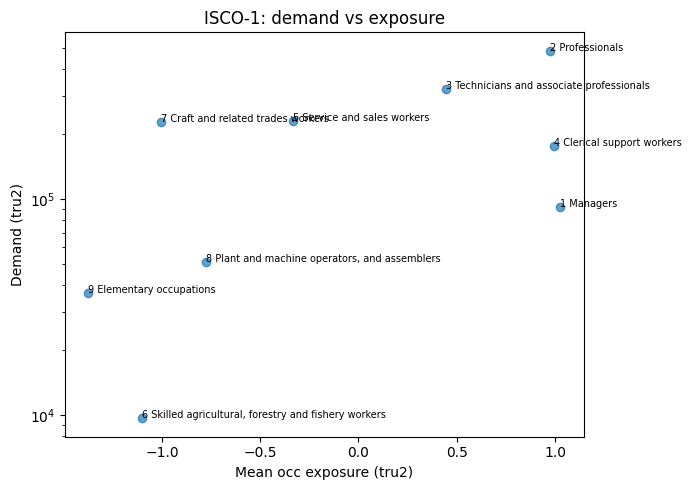

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_occ1_scatter.png


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

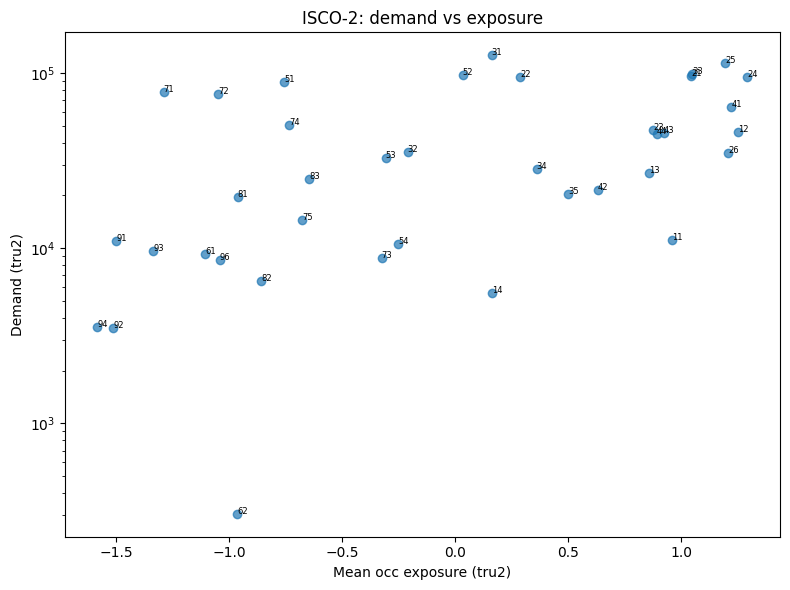

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_occ2_scatter_full.png


In [399]:
# Occupation impact lists (ISCO 1, 2, 4)

# Build codes/labels (in-memory)
_df["occ1_code"] = isco_raw_str.str[:1]
_df["occ1_label"] = _df["occu_isco1_label"].fillna("Unknown")
_df["occ2_code"] = isco_raw_str.str[:2]
_df["occ2_label"] = _df["occu_isco2_label"].fillna("Unknown")
_df["occ4_code"] = isco_raw_str
if "occu_isco4_label" in _df.columns:
    _df["occ4_label"] = _df["occu_isco4_label"].fillna(_df["occ4_code"])
else:
    _df["occ4_label"] = _df["occ4_code"]

# Weighted mean helper

def wmean(group, col):
    x = group[col]
    w = group["srvy_wght_tru2"]
    mask = x.notna()
    if mask.sum() == 0:
        return np.nan
    return np.average(x[mask], weights=w[mask])

# ISCO-1 full list
occ1_group = _df.groupby(["occ1_code", "occ1_label"])
occ1_metrics = occ1_group.agg(
    demand_total_tru2=("srvy_wght_tru2", "sum"),
    postings_total_tru1=("srvy_wght_tru1", "sum"),
    n_ads=("srvy_wght_tru2", "size")
).reset_index()
occ1_metrics["mean_occ_exp_tru2"] = occ1_group.apply(lambda g: wmean(g, occ_exp_col)).values
occ1_metrics = occ1_metrics.sort_values("mean_occ_exp_tru2", ascending=False)
occ1_metrics.to_csv(OUT_TABLES / "table_occ1_full.csv", index=False)
print("Saved", OUT_TABLES / "table_occ1_full.csv")

display(occ1_metrics)

# ISCO-2 full list
occ2_group = _df.groupby(["occ2_code", "occ2_label"])
occ2_metrics = occ2_group.agg(
    demand_total_tru2=("srvy_wght_tru2", "sum"),
    postings_total_tru1=("srvy_wght_tru1", "sum"),
    n_ads=("srvy_wght_tru2", "size")
).reset_index()
occ2_metrics["mean_occ_exp_tru2"] = occ2_group.apply(lambda g: wmean(g, occ_exp_col)).values
occ2_metrics = occ2_metrics.sort_values("mean_occ_exp_tru2", ascending=False)
occ2_metrics.to_csv(OUT_TABLES / "table_occ2_full.csv", index=False)
print("Saved", OUT_TABLES / "table_occ2_full.csv")

display(occ2_metrics)

# ISCO-4 top/bottom 25 by exposure (with labels)
occ4_group = _df.groupby(["occ4_code", "occ4_label"])
occ4_metrics = occ4_group.agg(
    demand_total_tru2=("srvy_wght_tru2", "sum"),
    postings_total_tru1=("srvy_wght_tru1", "sum"),
    n_ads=("srvy_wght_tru2", "size")
).reset_index()
occ4_metrics["mean_occ_exp_tru2"] = occ4_group.apply(lambda g: wmean(g, occ_exp_col)).values

occ4_top25 = occ4_metrics.nlargest(25, "mean_occ_exp_tru2")
occ4_bottom25 = occ4_metrics.nsmallest(25, "mean_occ_exp_tru2")

occ4_top25.to_csv(OUT_TABLES / "table_occ4_top25_exposure.csv", index=False)
occ4_bottom25.to_csv(OUT_TABLES / "table_occ4_bottom25_exposure.csv", index=False)
print("Saved", OUT_TABLES / "table_occ4_top25_exposure.csv")
print("Saved", OUT_TABLES / "table_occ4_bottom25_exposure.csv")

display(occ4_top25)
display(occ4_bottom25)

# Scatter: ISCO-1 demand vs exposure
plt.figure(figsize=(7,5))
plt.scatter(occ1_metrics["mean_occ_exp_tru2"], occ1_metrics["demand_total_tru2"], alpha=0.7)
for _, row in occ1_metrics.iterrows():
    label = f"{row['occ1_code']} {row['occ1_label']}"
    plt.text(row["mean_occ_exp_tru2"], row["demand_total_tru2"], label, fontsize=7)
plt.xlabel("Mean occ exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("ISCO‑1: demand vs exposure")
plt.tight_layout()
fig_path = OUT_VIS / "fig_occ1_scatter.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Scatter: ISCO-2 demand vs exposure (IDs only)
plt.figure(figsize=(8,6))
plt.scatter(occ2_metrics["mean_occ_exp_tru2"], occ2_metrics["demand_total_tru2"], alpha=0.7)
for _, row in occ2_metrics.iterrows():
    label = str(row["occ2_code"])
    plt.text(row["mean_occ_exp_tru2"], row["demand_total_tru2"], label, fontsize=6)
plt.xlabel("Mean occ exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("ISCO‑2: demand vs exposure")
plt.tight_layout()
fig_path = OUT_VIS / "fig_occ2_scatter_full.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


## 5.2) Impact zones — Industries (comp_indu_noga + NOGA section)


Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_ind_full_comp_noga.csv


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/4008556730.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ind_metrics["mean_ind_exp_tru2"] = ind_group.apply(lambda g: wmean(g, ind_exp_col)).values


,noga_code,noga_label,demand_total_tru2,postings_total_tru1,n_ads,mean_ind_exp_tru2
28,35,Activities auxiliary to financial and insuranc...,7319.281,7262.4957,231,2.114970
27,34,"Insurance, reinsurance and pension funding (ex...",34800.1121,32067.0302,1680,2.089173
26,33,Financial service activities,54843.9067,53028.7561,2527,2.032305
30,37,Legal and accounting activities; auditing; tax...,16349.1446,14666.688,275,1.658205
31,38,Activities of head offices; management consult...,18428.0581,18123.4947,296,1.603006
24,31,Publishing; audiovisual and broadcasting activ...,28163.8821,29027.8664,660,1.328372
37,43,Education,66308.8791,62208.8672,2925,1.186285
42,48,Membership organisations; religious and other ...,20243.5116,18620.9694,545,1.148076
25,32,Telecommunications; IT services; information s...,62738.4589,59590.8619,1893,0.988114
29,36,Real estate activities,14723.8277,14469.7835,561,0.947543


Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_ind_full_section.csv


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/4008556730.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sec_metrics["mean_sec_exp_tru2"] = sec_group.apply(lambda g: wmean(g, "industry_section_exposure_weighted")).values


,section_code,section_label,demand_total_tru2,postings_total_tru1,n_ads,mean_sec_exp_tru2
8,K,Financial and insurance activities,96963.2998,92358.282,4438,2.072848
13,P,Education,66308.8791,62208.8672,2925,1.186285
7,J,Information and communication,90902.341,88618.7283,2553,1.177146
10,M,"Professional, scientific and technical activities",164425.5273,158335.8369,4131,1.047356
9,L,Real estate activities,14723.8277,14469.7835,561,0.947543
14,Q,Human health and social work activities,209411.7959,184823.8547,8222,0.627138
4,G,Wholesale and retail trade; repair of motor ve...,231164.6441,216622.6414,7005,0.120153
16,S,Other service activities,31268.5622,28422.65,1058,0.099941
12,O,Public administration and defence; compulsory ...,43741.5326,39917.2254,2983,-0.063951
11,N,Administrative and support service activities,31162.4703,27547.8435,1312,-0.079286


Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_ind_top25_exposure.csv
Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_ind_bottom25_exposure.csv


,noga_code,noga_label,demand_total_tru2,postings_total_tru1,n_ads,mean_ind_exp_tru2
28,35,Activities auxiliary to financial and insuranc...,7319.281,7262.4957,231,2.114970
27,34,"Insurance, reinsurance and pension funding (ex...",34800.1121,32067.0302,1680,2.089173
26,33,Financial service activities,54843.9067,53028.7561,2527,2.032305
30,37,Legal and accounting activities; auditing; tax...,16349.1446,14666.688,275,1.658205
31,38,Activities of head offices; management consult...,18428.0581,18123.4947,296,1.603006
24,31,Publishing; audiovisual and broadcasting activ...,28163.8821,29027.8664,660,1.328372
37,43,Education,66308.8791,62208.8672,2925,1.186285
42,48,Membership organisations; religious and other ...,20243.5116,18620.9694,545,1.148076
25,32,Telecommunications; IT services; information s...,62738.4589,59590.8619,1893,0.988114
29,36,Real estate activities,14723.8277,14469.7835,561,0.947543


,noga_code,noga_label,demand_total_tru2,postings_total_tru1,n_ads,mean_ind_exp_tru2
13,21,Specialised construction activities,96390.5839,85354.4148,3237,-1.280567
20,28,Postal and courier activities,14339.8674,12108.9048,482,-1.216001
23,30,Food and beverage service activities,54225.6532,49205.8672,1864,-1.083814
0,1,"Agriculture, forestry and fishing",5606.3021,4378.4785,359,-1.034561
33,4,"Manufacture of wood and of products of wood, s...",12361.7932,11953.3618,325,-0.991795
19,27,Warehousing and support activities for transpo...,15597.1818,17034.3386,706,-0.959934
12,20,Civil engineering,7615.4405,6489.3336,283,-0.933696
11,2,Manufacture of food products and tobacco products,18587.4235,16931.2629,977,-0.922206
2,11,Manufacture and processing of basic metals,19332.6856,18499.2555,850,-0.904773
21,29,Accommodation,19395.5887,18855.2013,288,-0.815391


Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_section_top25_exposure.csv
Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_section_bottom25_exposure.csv


,section_code,section_label,demand_total_tru2,postings_total_tru1,n_ads,mean_sec_exp_tru2
8,K,Financial and insurance activities,96963.2998,92358.282,4438,2.072848
13,P,Education,66308.8791,62208.8672,2925,1.186285
7,J,Information and communication,90902.341,88618.7283,2553,1.177146
10,M,"Professional, scientific and technical activities",164425.5273,158335.8369,4131,1.047356
9,L,Real estate activities,14723.8277,14469.7835,561,0.947543
14,Q,Human health and social work activities,209411.7959,184823.8547,8222,0.627138
4,G,Wholesale and retail trade; repair of motor ve...,231164.6441,216622.6414,7005,0.120153
16,S,Other service activities,31268.5622,28422.65,1058,0.099941
12,O,Public administration and defence; compulsory ...,43741.5326,39917.2254,2983,-0.063951
11,N,Administrative and support service activities,31162.4703,27547.8435,1312,-0.079286


,section_code,section_label,demand_total_tru2,postings_total_tru1,n_ads,mean_sec_exp_tru2
3,F,Construction,123097.7805,108705.1626,4047,-1.128442
0,AB,"Agriculture, forestry, fishing and mining",5606.3021,4378.4785,359,-1.034561
6,I,Accommodation and food service activities,73621.2419,68061.0685,2152,-0.986206
2,DE,"Electricity, gas, water supply; sewerage, wast...",24200.1723,23039.6806,982,-0.625946
5,H,Transportation and storage,62305.0081,57961.7257,2438,-0.525983
1,C,Manufacturing,276762.2627,261290.6626,11496,-0.450426
15,R,"Arts, entertainment and recreation",8916.6844,7491.1904,468,-0.144358
11,N,Administrative and support service activities,31162.4703,27547.8435,1312,-0.079286
12,O,Public administration and defence; compulsory ...,43741.5326,39917.2254,2983,-0.063951
16,S,Other service activities,31268.5622,28422.65,1058,0.099941


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


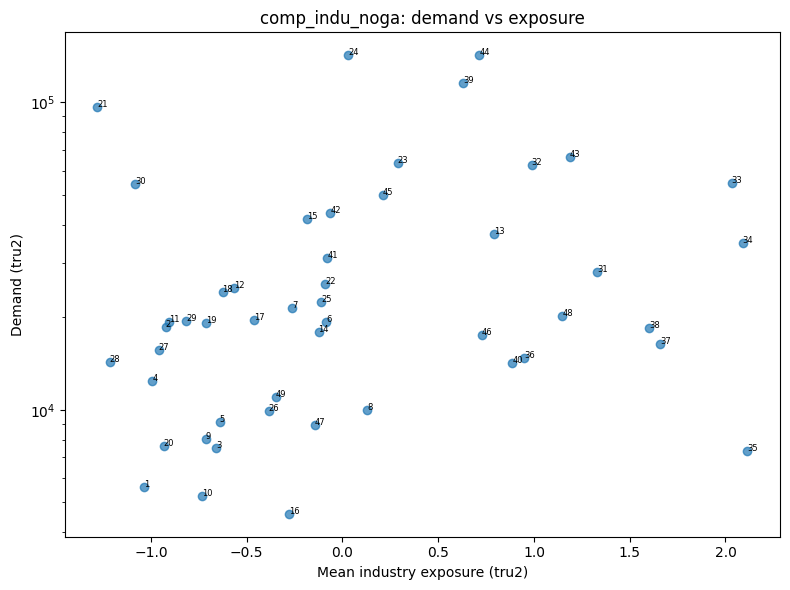

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_ind_scatter_full.png


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


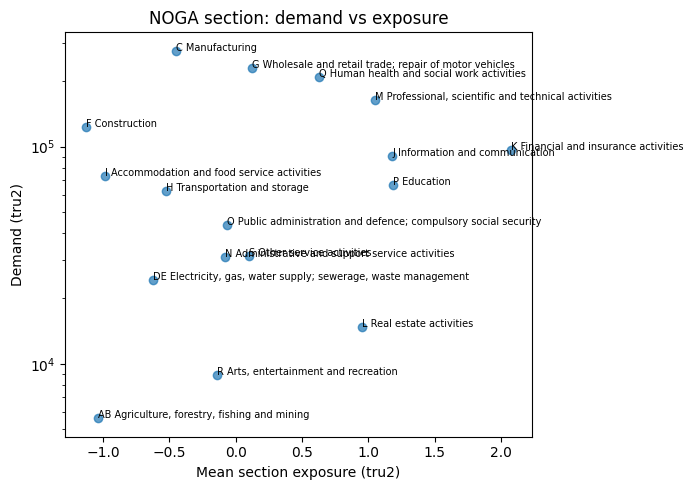

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_section_scatter_full.png


In [400]:
# Industry impact lists (comp_indu_noga + NOGA section)

# comp_indu_noga full list
_df["noga_code"] = _df["comp_indu_noga"].astype("string")
_df["noga_label"] = _df["comp_indu_noga_label"].fillna("Unknown")

ind_group = _df.groupby(["noga_code", "noga_label"])
ind_metrics = ind_group.agg(
    demand_total_tru2=("srvy_wght_tru2","sum"),
    postings_total_tru1=("srvy_wght_tru1","sum"),
    n_ads=("srvy_wght_tru2","size")
).reset_index()
ind_metrics["mean_ind_exp_tru2"] = ind_group.apply(lambda g: wmean(g, ind_exp_col)).values
ind_metrics = ind_metrics.sort_values("mean_ind_exp_tru2", ascending=False)
ind_metrics.to_csv(OUT_TABLES / "table_ind_full_comp_noga.csv", index=False)
print("Saved", OUT_TABLES / "table_ind_full_comp_noga.csv")

display(ind_metrics)

# NOGA section full list
_df["section_code"] = _df["industry_section"].astype("string")
_df["section_label"] = _df["industry_section_label"].fillna(_df["industry_section"]).fillna("Unknown")

sec_group = _df.groupby(["section_code", "section_label"])
sec_metrics = sec_group.agg(
    demand_total_tru2=("srvy_wght_tru2","sum"),
    postings_total_tru1=("srvy_wght_tru1","sum"),
    n_ads=("srvy_wght_tru2","size")
).reset_index()
sec_metrics["mean_sec_exp_tru2"] = sec_group.apply(lambda g: wmean(g, "industry_section_exposure_weighted")).values
sec_metrics = sec_metrics.sort_values("mean_sec_exp_tru2", ascending=False)
sec_metrics.to_csv(OUT_TABLES / "table_ind_full_section.csv", index=False)
print("Saved", OUT_TABLES / "table_ind_full_section.csv")

display(sec_metrics)

# Top/Bottom 25 comp_indu_noga by exposure (tables)
ind_top25 = ind_metrics.nlargest(25, "mean_ind_exp_tru2")
ind_bottom25 = ind_metrics.nsmallest(25, "mean_ind_exp_tru2")
ind_top25.to_csv(OUT_TABLES / "table_ind_top25_exposure.csv", index=False)
ind_bottom25.to_csv(OUT_TABLES / "table_ind_bottom25_exposure.csv", index=False)
print("Saved", OUT_TABLES / "table_ind_top25_exposure.csv")
print("Saved", OUT_TABLES / "table_ind_bottom25_exposure.csv")

display(ind_top25)
display(ind_bottom25)

# Top/Bottom 25 NOGA sections by exposure (tables)
sec_top25 = sec_metrics.nlargest(25, "mean_sec_exp_tru2")
sec_bottom25 = sec_metrics.nsmallest(25, "mean_sec_exp_tru2")
sec_top25.to_csv(OUT_TABLES / "table_section_top25_exposure.csv", index=False)
sec_bottom25.to_csv(OUT_TABLES / "table_section_bottom25_exposure.csv", index=False)
print("Saved", OUT_TABLES / "table_section_top25_exposure.csv")
print("Saved", OUT_TABLES / "table_section_bottom25_exposure.csv")

display(sec_top25)
display(sec_bottom25)

# Scatter: comp_indu_noga demand vs exposure (IDs only)
plt.figure(figsize=(8,6))
plt.scatter(ind_metrics["mean_ind_exp_tru2"], ind_metrics["demand_total_tru2"], alpha=0.7)
for _, row in ind_metrics.iterrows():
    label = str(row["noga_code"])
    plt.text(row["mean_ind_exp_tru2"], row["demand_total_tru2"], label, fontsize=6)
plt.xlabel("Mean industry exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("comp_indu_noga: demand vs exposure")
plt.tight_layout()
fig_path = OUT_VIS / "fig_ind_scatter_full.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Scatter: NOGA section demand vs exposure
plt.figure(figsize=(7,5))
plt.scatter(sec_metrics["mean_sec_exp_tru2"], sec_metrics["demand_total_tru2"], alpha=0.7)
for _, row in sec_metrics.iterrows():
    label = f"{row['section_code']} {row['section_label']}"
    plt.text(row["mean_sec_exp_tru2"], row["demand_total_tru2"], label, fontsize=7)
plt.xlabel("Mean section exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("NOGA section: demand vs exposure")
plt.tight_layout()
fig_path = OUT_VIS / "fig_section_scatter_full.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


## 6) Regions (Unknown kept)

### 6.1) Regions — occupation exposure


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/3672033963.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reg_metrics["mean_occ_exp_tru2"] = reg_group.apply(wmean_region)
/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/3672033963.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  known_denom = reg_group.apply(lambda g: g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"]

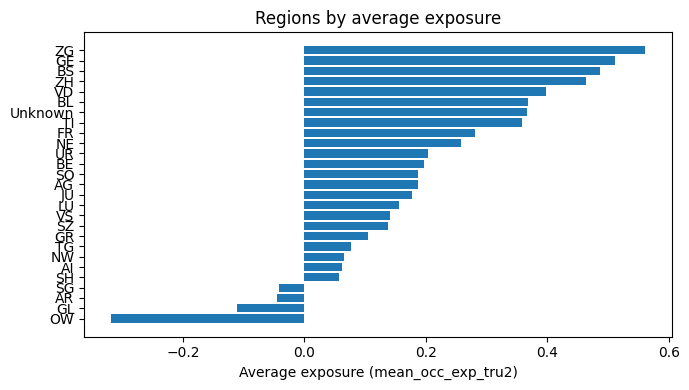

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top30_avg_exposure.png


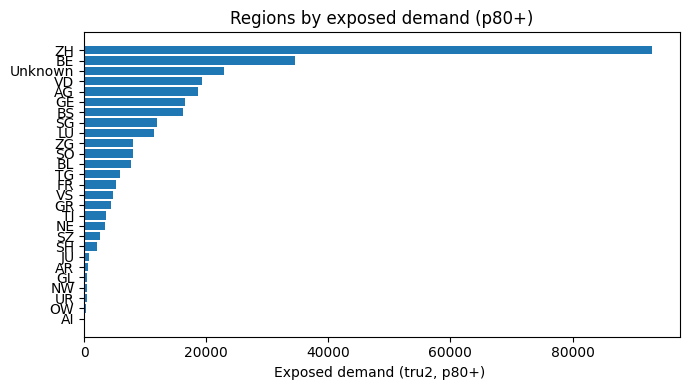

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top15_exposed_p80.png


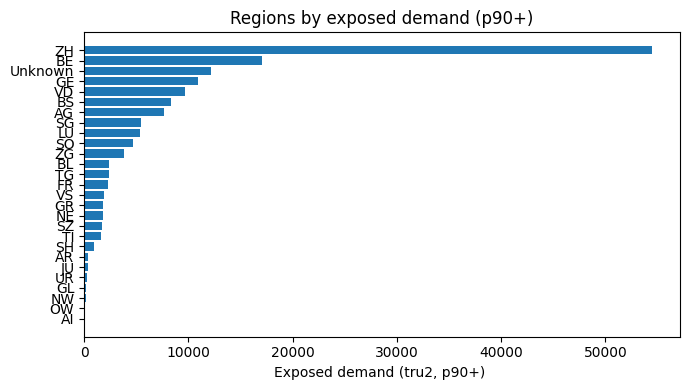

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top15_exposed_p90.png


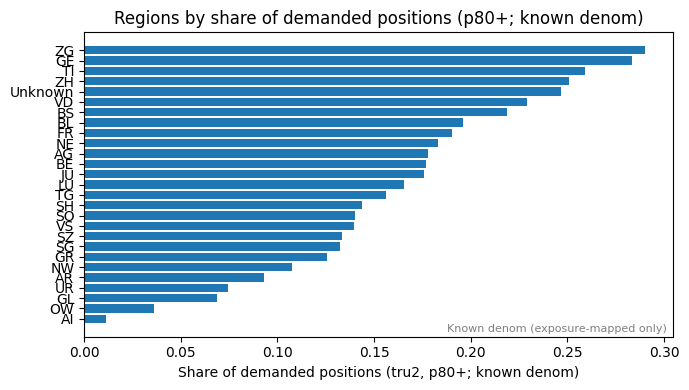

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top30_share_p80.png


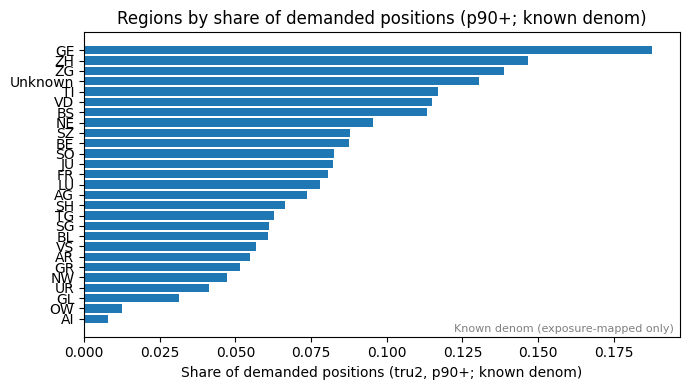

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top30_share_p90.png


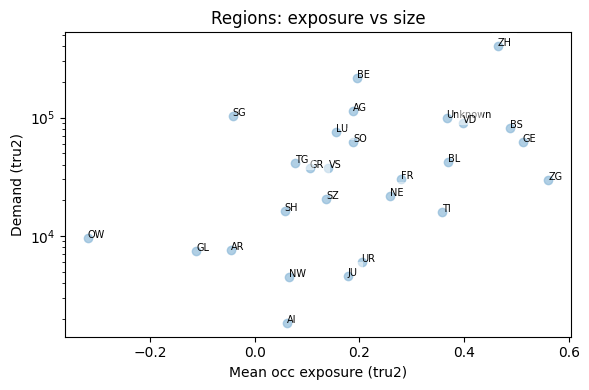

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_scatter.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/3672033963.py:169: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g[occ_exp_col].dropna(), weights=g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"])


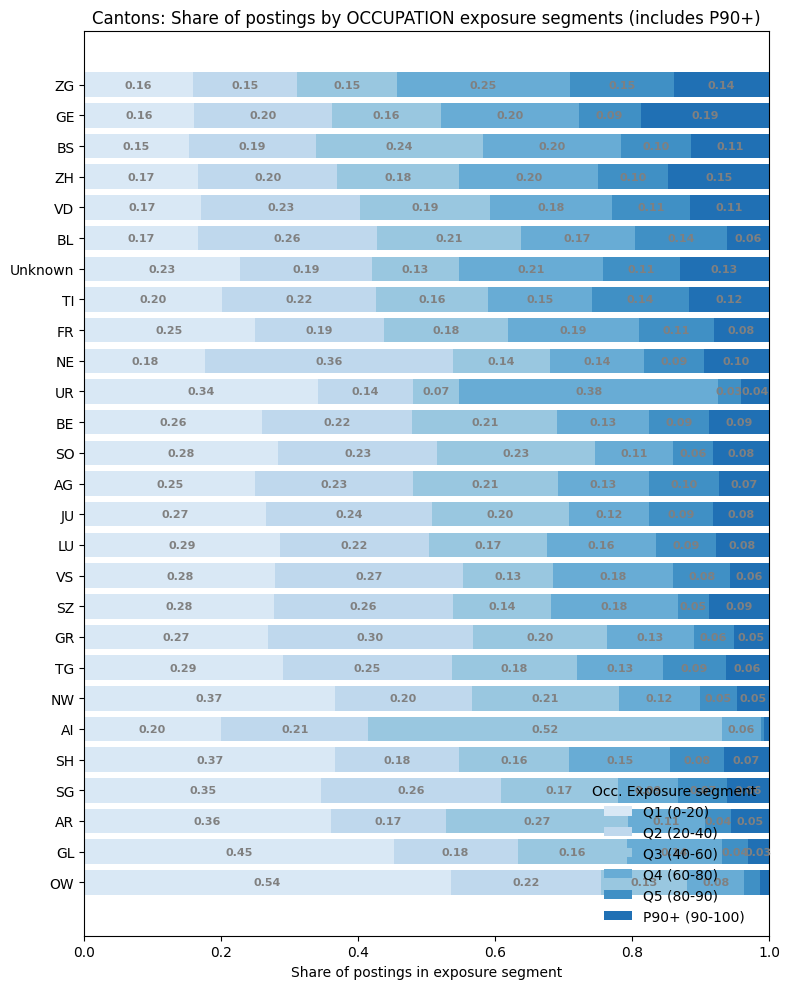

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_kanton_stack_segments_occ_exp.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/3672033963.py:229: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(


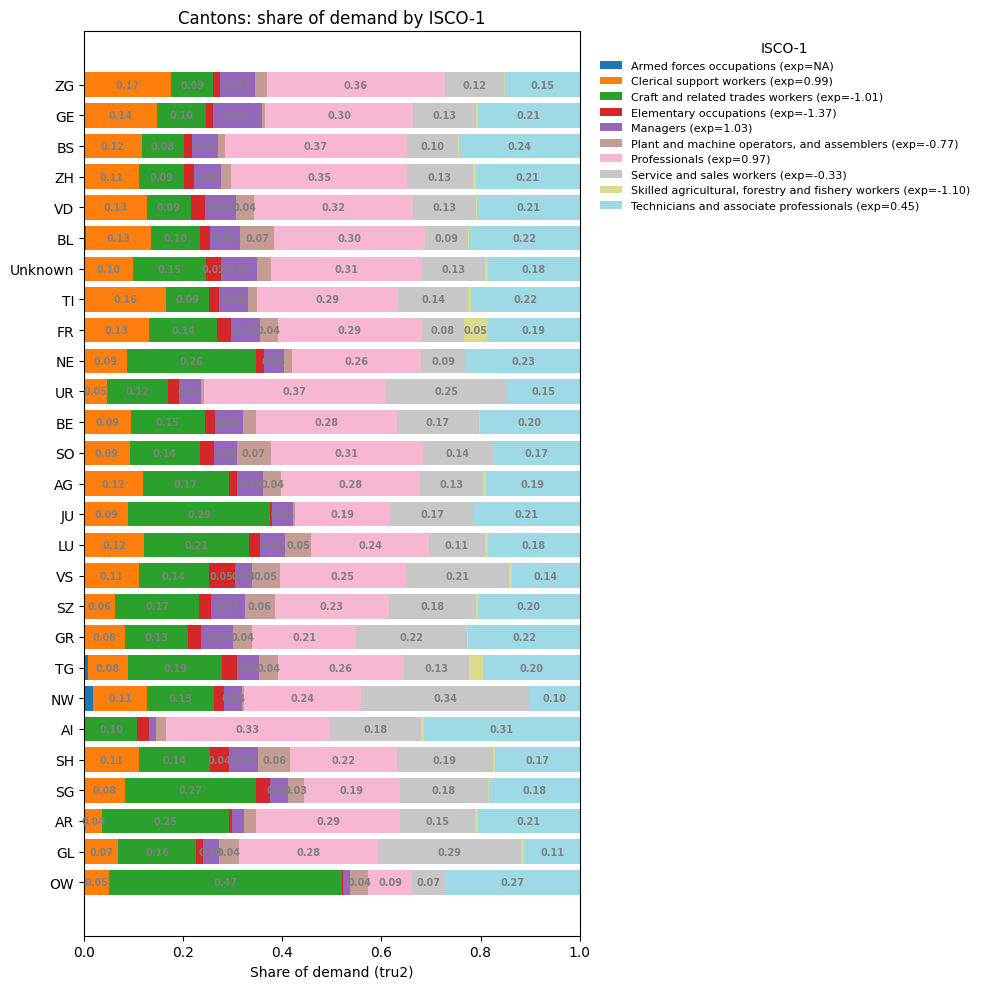

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_kanton_stack_isco1_share.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/3672033963.py:286: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(


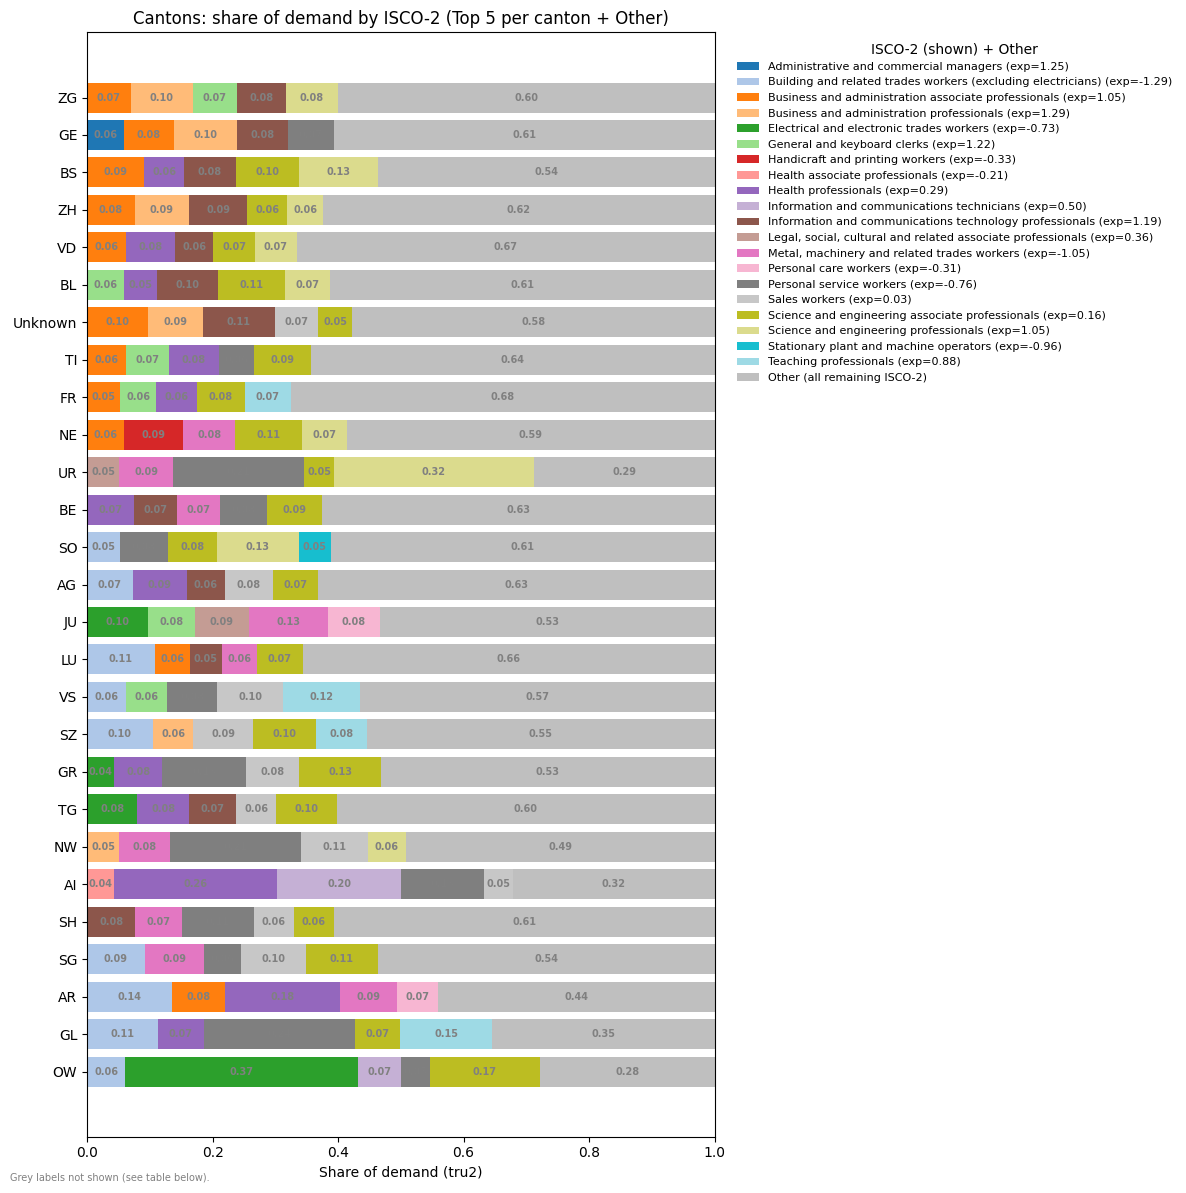

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_kanton_stack_isco2_share.png


,_occ2_code,_occ2_label,note
0,00,Unknown,Not in top 5 for any canton
43,01,Commissioned armed forces officers,Not in top 5 for any canton
44,03,"Armed forces occupations, other ranks",Not in top 5 for any canton
1,10,Unknown sub-major (major group only),Not in top 5 for any canton
2,11,"Chief executives, senior officials and legisla...",Not in top 5 for any canton
4,13,Production and specialised services managers,Not in top 5 for any canton
5,14,"Hospitality, retail and other services managers",Not in top 5 for any canton
6,20,Unknown sub-major (major group only),Not in top 5 for any canton
12,26,"Legal, social and cultural professionals",Not in top 5 for any canton
13,30,Unknown sub-major (major group only),Not in top 5 for any canton


In [401]:
region_col = "loca_regi_kant_label"

# Region summary
reg_group = _df.groupby(region_col)

def wmean_region(g):
    x = g.loc[g[occ_exp_col].notna(), occ_exp_col]
    w = g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"]
    return np.average(x, weights=w) if len(x) else np.nan

reg_metrics = reg_group.agg(
    demand_total_tru2=("srvy_wght_tru2","sum"),
    postings_total_tru1=("srvy_wght_tru1","sum")
)
reg_metrics["mean_occ_exp_tru2"] = reg_group.apply(wmean_region)

# exposed demand p80/p90
reg_metrics["exposed_demand_p80"] = _df.loc[_df[occ_exp_col] >= occ_p80].groupby(region_col)["srvy_wght_tru2"].sum()
reg_metrics["exposed_demand_p90"] = _df.loc[_df[occ_exp_col] >= occ_p90].groupby(region_col)["srvy_wght_tru2"].sum()
reg_metrics = reg_metrics.fillna(0)

# shares
known_denom = reg_group.apply(lambda g: g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"].sum())
reg_metrics["high_share_total_p80"] = reg_metrics["exposed_demand_p80"] / reg_metrics["demand_total_tru2"]
reg_metrics["high_share_known_p80"] = reg_metrics["exposed_demand_p80"] / known_denom
reg_metrics["coverage_share"] = known_denom / reg_metrics["demand_total_tru2"]

reg_metrics["high_share_total_p90"] = reg_metrics["exposed_demand_p90"] / reg_metrics["demand_total_tru2"]
reg_metrics["high_share_known_p90"] = reg_metrics["exposed_demand_p90"] / known_denom
reg_metrics = reg_metrics.reset_index()
reg_metrics.to_csv(OUT_TABLES / "table_region_summary.csv", index=False)

# Bar charts
# Plot bar chart for average exposure (mean_occ_exp_tru2) by region
top_reg_exp = reg_metrics.nlargest(30, "mean_occ_exp_tru2")
plt.figure(figsize=(7,4))
plt.barh(top_reg_exp[region_col].astype(str), top_reg_exp["mean_occ_exp_tru2"])
plt.gca().invert_yaxis()
plt.xlabel("Average exposure (mean_occ_exp_tru2)")
plt.title("Regions by average exposure")
plt.tight_layout()
fig_path = OUT_VIS / "fig_region_top30_avg_exposure.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


for thresh_label in ["p80","p90"]:
    col = f"exposed_demand_{thresh_label}"
    top_reg = reg_metrics.nlargest(30, col)
    plt.figure(figsize=(7,4))
    plt.barh(top_reg[region_col].astype(str), top_reg[col])
    plt.gca().invert_yaxis()
    plt.xlabel(f"Exposed demand (tru2, {thresh_label}+) ")
    plt.title(f"Regions by exposed demand ({thresh_label}+)")
    plt.tight_layout()
    fig_path = OUT_VIS / f"fig_region_top15_exposed_{thresh_label}.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Saved", fig_path)

# Plots for share of demanded positions (high_share_total_p80 and high_share_total_p90) by region

# high_share_total_p80 already exists,
# For high_share_total_p90, compute it first

for thresh_label in ["p80", "p90"]:
    share_col = f"high_share_known_{thresh_label}"
    plot_data = reg_metrics.copy()
    plot_data[region_col] = plot_data[region_col].fillna("Unknown")
    plot_data[share_col] = pd.to_numeric(plot_data[share_col], errors="coerce").fillna(0)
    top_reg_share = plot_data.nlargest(30, share_col)
    plt.figure(figsize=(7,4))
    plt.barh(top_reg_share[region_col].astype(str), top_reg_share[share_col])
    plt.gca().invert_yaxis()
    plt.xlabel(f"Share of demanded positions (tru2, {thresh_label}+; known denom)")
    plt.title(f"Regions by share of demanded positions ({thresh_label}+; known denom)")
    plt.text(0.99, 0.01, 'Known denom (exposure-mapped only)', transform=plt.gca().transAxes, ha='right', va='bottom', fontsize=8, color='gray')
    plt.tight_layout()
    fig_path = OUT_VIS / f"fig_region_top30_share_{thresh_label}.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Saved", fig_path)



# Scatter
plt.figure(figsize=(6,4))
plt.scatter(reg_metrics["mean_occ_exp_tru2"], reg_metrics["demand_total_tru2"], alpha=0.7)
label_set = set()
label_set.update(reg_metrics.nlargest(30, "demand_total_tru2")[region_col].tolist())
label_set.update(reg_metrics.nlargest(30, "mean_occ_exp_tru2")[region_col].tolist())
if "Unknown" in reg_metrics[region_col].values:
    label_set.add("Unknown")
for _, row in reg_metrics[reg_metrics[region_col].isin(label_set)].iterrows():
    plt.text(row["mean_occ_exp_tru2"], row["demand_total_tru2"], str(row[region_col]), fontsize=7,
             bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
plt.xlabel("Mean occ exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("Regions: exposure vs size")
plt.tight_layout()
fig_path = OUT_VIS / "fig_region_scatter.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Decomposition: top 5 regions by exposed demand (p80)
reg_metrics_sorted = reg_metrics.sort_values("exposed_demand_p80", ascending=False)
top_regions = reg_metrics_sorted.head(5)[region_col].tolist()
rows_occ = []
rows_ind = []
for reg in top_regions:
    sub = _df[(_df[region_col] == reg) & (_df[occ_exp_col] >= occ_p80)]
    # top occ2
    sub_occ = sub.groupby(occ2_label)["srvy_wght_tru2"].sum().sort_values(ascending=False).head(5)
    for rank, (code, val) in enumerate(sub_occ.items(), start=1):
        rows_occ.append({"region": reg, "rank": rank, "occ2_label": code, "exposed_demand_tru2": val})
    # top industries
    sub_ind = sub.groupby(_df["comp_indu_noga_label"].fillna("Unknown"))["srvy_wght_tru2"].sum().sort_values(ascending=False).head(5)
    for rank, (code, val) in enumerate(sub_ind.items(), start=1):
        rows_ind.append({"region": reg, "rank": rank, "indu_label": code, "exposed_demand_tru2": val})

pd.DataFrame(rows_occ).to_csv(OUT_TABLES / "table_region_top_occ2_contrib.csv", index=False)
pd.DataFrame(rows_ind).to_csv(OUT_TABLES / "table_region_top_ind_contrib.csv", index=False)


# === Plot: horizontal stacked bars for exposure segments per canton (OCCUPATION exposure, includes P90+) ===
# Build exposure segments using global p20/p40/p60/p80/p90 thresholds
occ_p20_seg, occ_p40_seg, occ_p60_seg = occ_p20, occ_p40, occ_p60
occ_p80_seg, occ_p90_seg = occ_p80, occ_p90

def _occ_segment(x):
    if pd.isna(x):
        return pd.NA
    if x <= occ_p20:
        return "Q1 (0-20)"
    if x <= occ_p40:
        return "Q2 (20-40)"
    if x <= occ_p60:
        return "Q3 (40-60)"
    if x <= occ_p80_seg:
        return "Q4 (60-80)"
    if x < occ_p90_seg:
        return "Q5 (80-90)"
    return "P90+ (90-100)"

_df["occ_exposure_segment"] = _df[occ_exp_col].apply(_occ_segment)
segments = ["Q1 (0-20)", "Q2 (20-40)", "Q3 (40-60)", "Q4 (60-80)", "Q5 (80-90)", "P90+ (90-100)"]

postings_per_kanton_segment = (
    _df[_df[region_col].notna() & _df["occ_exposure_segment"].notna()]
      .groupby([region_col, "occ_exposure_segment"], observed=True)["srvy_wght_tru2"].sum()
      .unstack(fill_value=0)
)
for seg in segments:
    if seg not in postings_per_kanton_segment.columns:
        postings_per_kanton_segment[seg] = 0

postings_per_kanton_segment_share = postings_per_kanton_segment.div(
    postings_per_kanton_segment.sum(axis=1), axis=0
)
postings_per_kanton_segment_share = postings_per_kanton_segment_share.loc[
    postings_per_kanton_segment_share.sum(axis=1) > 0
]

mean_exposure_by_kanton = (
    _df.groupby(region_col)
    .apply(lambda g: np.average(g[occ_exp_col].dropna(), weights=g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"])
           if g[occ_exp_col].notna().any() else 0)
)
plot_order = mean_exposure_by_kanton.loc[postings_per_kanton_segment_share.index].sort_values(ascending=True).index.tolist()
postings_per_kanton_segment_share = postings_per_kanton_segment_share.loc[plot_order]

fig, ax = plt.subplots(figsize=(8, 10))

colormap = plt.get_cmap("Blues")
segment_colors = [colormap(0.15 + 0.12*i) for i in range(len(segments))]

bottom = np.zeros(len(postings_per_kanton_segment_share))
y_labels = postings_per_kanton_segment_share.index.astype(str)

for i, seg in enumerate(segments):
    vals = postings_per_kanton_segment_share[seg].values
    bars = ax.barh(
        y_labels,
        vals,
        left=bottom,
        height=0.8,
        color=segment_colors[i],
        label=seg
    )
    for j, (bar, share) in enumerate(zip(bars, vals)):
        if np.isfinite(share) and share >= 0.03:
            xpos = bottom[j] + share/2
            ypos = bar.get_y() + bar.get_height()/2
            ax.text(
                xpos,
                ypos,
                f"{share:.2f}",
                ha="center",
                va="center",
                color="grey",
                fontsize=8,
                fontweight="bold"
            )
    bottom += vals

ax.set_xlabel("Share of postings in exposure segment")
ax.set_title("Cantons: Share of postings by OCCUPATION exposure segments (includes P90+)")
ax.set_xlim(0, 1)
ax.legend(title="Occ. Exposure segment", loc="lower right", frameon=False)
plt.tight_layout()

fig_path = OUT_VIS / "fig_kanton_stack_segments_occ_exp.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


# === Plot: share of demand by ISCO-1 (stacked bars) ===
# === Plot: share of demand by ISCO-1 (stacked bars) ===
occ1_label = _df["occu_isco1_label"].fillna("Unknown")

# exposure per ISCO-1 label (tru2-weighted)
occ1_exp_map = (
    _df.assign(_occ1=occ1_label)
       .groupby("_occ1", observed=True)
       .apply(lambda g: np.average(
           g.loc[g[occ_exp_col].notna(), occ_exp_col],
           weights=g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"]
       ) if g[occ_exp_col].notna().any() else np.nan)
)
occ1_label_exp = occ1_label.map(lambda lab: f"{lab} (exp={occ1_exp_map.get(lab, float('nan')):.2f})" if pd.notna(occ1_exp_map.get(lab, np.nan)) else f"{lab} (exp=NA)")

occ1_by_kanton = (
    _df[_df[region_col].notna()]
      .assign(_occ1=occ1_label_exp)
      .groupby([region_col, "_occ1"], observed=True)["srvy_wght_tru2"].sum()
      .unstack(fill_value=0)
)

occ1_share = occ1_by_kanton.div(occ1_by_kanton.sum(axis=1), axis=0)
occ1_share = occ1_share.loc[occ1_share.sum(axis=1) > 0]

# Use same ordering as exposure segments if available
try:
    occ1_share = occ1_share.loc[plot_order]
except Exception:
    pass

fig, ax = plt.subplots(figsize=(10, 10))
labels = occ1_share.index.astype(str)
category_cols = occ1_share.columns.tolist()
cmap = plt.get_cmap("tab20", len(category_cols))
colors = [cmap(i) for i in range(len(category_cols))]

bottom = np.zeros(len(occ1_share))
for i, cat in enumerate(category_cols):
    vals = occ1_share[cat].values
    bars = ax.barh(labels, vals, left=bottom, height=0.8, color=colors[i], label=cat)
    for j, (bar, share) in enumerate(zip(bars, vals)):
        if np.isfinite(share) and share >= 0.03:
            ax.text(bottom[j] + share/2, bar.get_y() + bar.get_height()/2, f"{share:.2f}",
                    ha="center", va="center", color="grey", fontsize=7, fontweight="bold")
    bottom += vals

ax.set_xlabel("Share of demand (tru2)")
ax.set_title("Cantons: share of demand by ISCO-1")
ax.set_xlim(0, 1)
ax.legend(title="ISCO-1", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False, fontsize=8)
plt.tight_layout()
fig_path = OUT_VIS / "fig_kanton_stack_isco1_share.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# === Plot: share of demand by ISCO-2 (Top 5 per canton + Other) ===
occ2_code = isco_raw_str.str[:2]
occ2_label = _df["occu_isco2_label"].fillna("Unknown")

# exposure per ISCO-2 label (tru2-weighted)
occ2_exp_map = (
    _df.assign(_occ2=occ2_label)
       .groupby("_occ2", observed=True)
       .apply(lambda g: np.average(
           g.loc[g[occ_exp_col].notna(), occ_exp_col],
           weights=g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"]
       ) if g[occ_exp_col].notna().any() else np.nan)
)
occ2_label_exp = occ2_label.map(lambda lab: f"{lab} (exp={occ2_exp_map.get(lab, float('nan')):.2f})" if pd.notna(occ2_exp_map.get(lab, np.nan)) else f"{lab} (exp=NA)")

# Demand per canton x ISCO-2
occ2_demand = (
    _df[_df[region_col].notna()]
      .assign(_occ2_code=occ2_code, _occ2_label=occ2_label, _occ2_label_exp=occ2_label_exp)
      .groupby([region_col, "_occ2_code", "_occ2_label", "_occ2_label_exp"], observed=True)["srvy_wght_tru2"].sum()
      .reset_index()
)

# Total per canton
canton_totals = occ2_demand.groupby(region_col)["srvy_wght_tru2"].sum().rename("total").reset_index()
occ2_demand = occ2_demand.merge(canton_totals, on=region_col, how="left")
occ2_demand["share"] = occ2_demand["srvy_wght_tru2"] / occ2_demand["total"]

# Top 5 per canton
occ2_demand["rank"] = occ2_demand.groupby(region_col)["share"].rank(method="first", ascending=False)
occ2_top = occ2_demand[occ2_demand["rank"] <= 5].copy()

# Build wide table (top5 per canton + other)
occ2_pivot = occ2_top.pivot_table(index=region_col, columns="_occ2_label_exp", values="share", fill_value=0)

# Other share per canton
other_share = occ2_demand[occ2_demand["rank"] > 5].groupby(region_col)["share"].sum()
occ2_pivot["Other (all remaining ISCO-2)"] = other_share
occ2_pivot = occ2_pivot.fillna(0)

try:
    occ2_pivot = occ2_pivot.loc[plot_order]
except Exception:
    pass

# Colors: distinct for labels shown at least once; grey for Other
shown_labels = [c for c in occ2_pivot.columns if c != "Other (all remaining ISCO-2)"]

cmap = plt.get_cmap("tab20", len(shown_labels))
color_map = {lab: cmap(i) for i, lab in enumerate(shown_labels)}
color_map["Other (all remaining ISCO-2)"] = (0.75, 0.75, 0.75, 1.0)

fig, ax = plt.subplots(figsize=(12, 12))
labels = occ2_pivot.index.astype(str)
category_cols = occ2_pivot.columns.tolist()

bottom = np.zeros(len(occ2_pivot))
for cat in category_cols:
    vals = occ2_pivot[cat].values
    bars = ax.barh(labels, vals, left=bottom, height=0.8, color=color_map[cat], label=cat)
    for j, (bar, share) in enumerate(zip(bars, vals)):
        if np.isfinite(share) and share >= 0.03:
            ax.text(bottom[j] + share/2, bar.get_y() + bar.get_height()/2, f"{share:.2f}",
                    ha="center", va="center", color="grey", fontsize=7, fontweight="bold")
    bottom += vals

ax.set_xlabel("Share of demand (tru2)")
ax.set_title("Cantons: share of demand by ISCO-2 (Top 5 per canton + Other)")
ax.set_xlim(0, 1)
ax.legend(title="ISCO-2 (shown) + Other", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False, fontsize=8)

# List labels never shown in top5
all_labels = occ2_demand[["_occ2_code", "_occ2_label"]].drop_duplicates()
shown_codes = occ2_top[["_occ2_code", "_occ2_label"]].drop_duplicates()
not_shown = all_labels.merge(shown_codes, on=["_occ2_code", "_occ2_label"], how="left", indicator=True)
not_shown = not_shown[not_shown["_merge"] == "left_only"].drop(columns=["_merge"]).sort_values("_occ2_code")
not_shown["note"] = "Not in top 5 for any canton"

if not_shown.shape[0] > 0:
    fig.text(0.01, 0.01, "Grey labels not shown (see table below).", fontsize=7, color="grey", ha="left", va="bottom")

plt.tight_layout()
fig_path = OUT_VIS / "fig_kanton_stack_isco2_share.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

display(not_shown)


### 6.2) Regions — industry exposure


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/3060603006.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_ind_exp_by_kanton = indreg_group.apply(wmean_industry_exp).reset_index(name="mean_ind_exp_tru2")


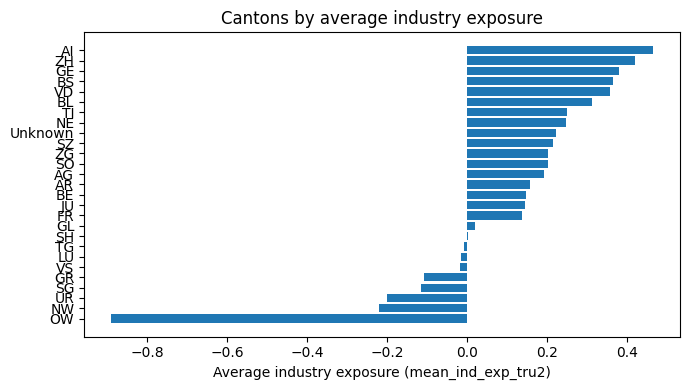

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_canton_top30_avg_industry_exposure.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/3060603006.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reg_metrics_ind["mean_ind_exp_tru2"] = ind_reg_group.apply(wmean_industry_exp)
/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/3060603006.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  known_denom_ind = ind_reg_group.apply(lambda g: g.loc[g[ind_exp_col].notn

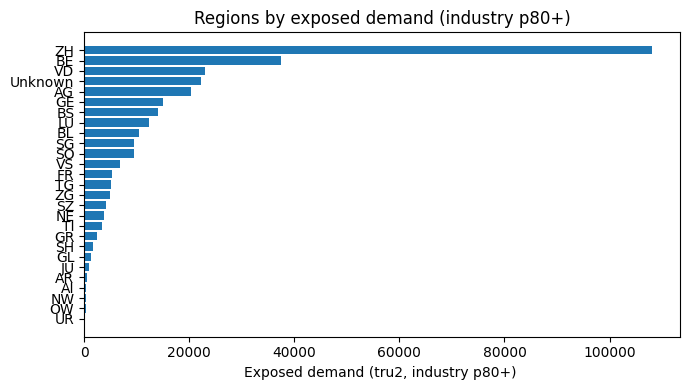

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top15_exposed_p80_ind.png


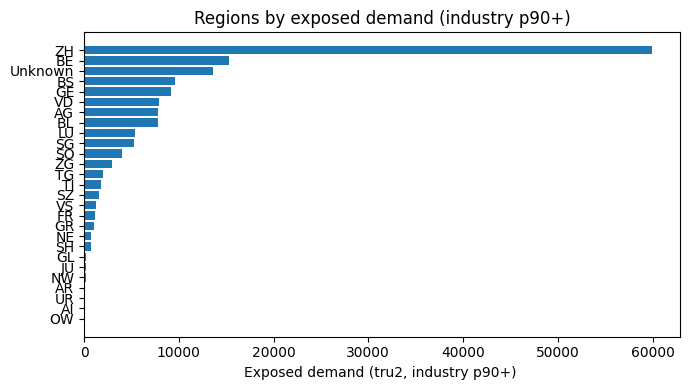

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top15_exposed_p90_ind.png


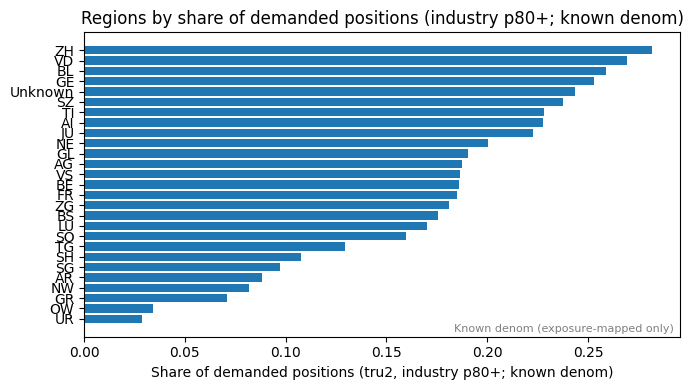

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top30_share_p80_ind.png


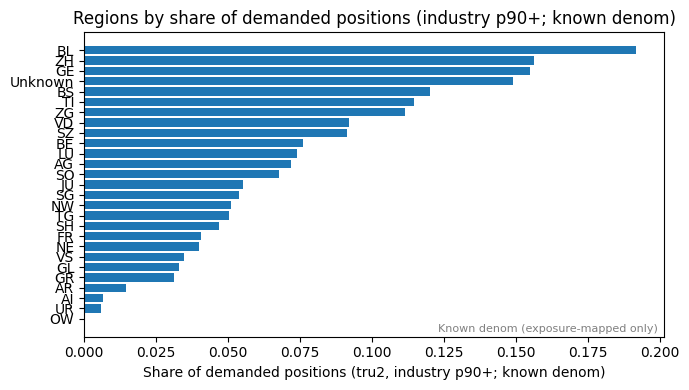

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top30_share_p90_ind.png


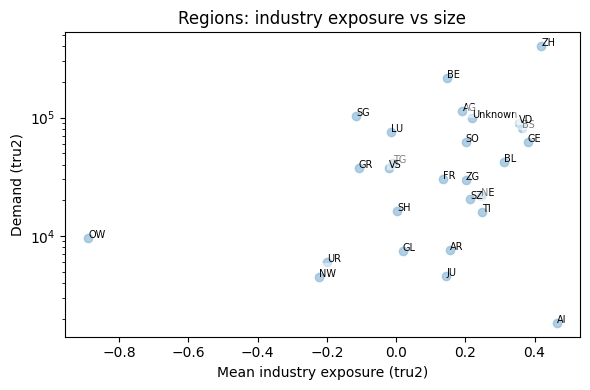

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_scatter_ind.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/3060603006.py:171: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g[ind_exp_col].dropna(), weights=g.loc[g[ind_exp_col].notna(), "srvy_wght_tru2"])


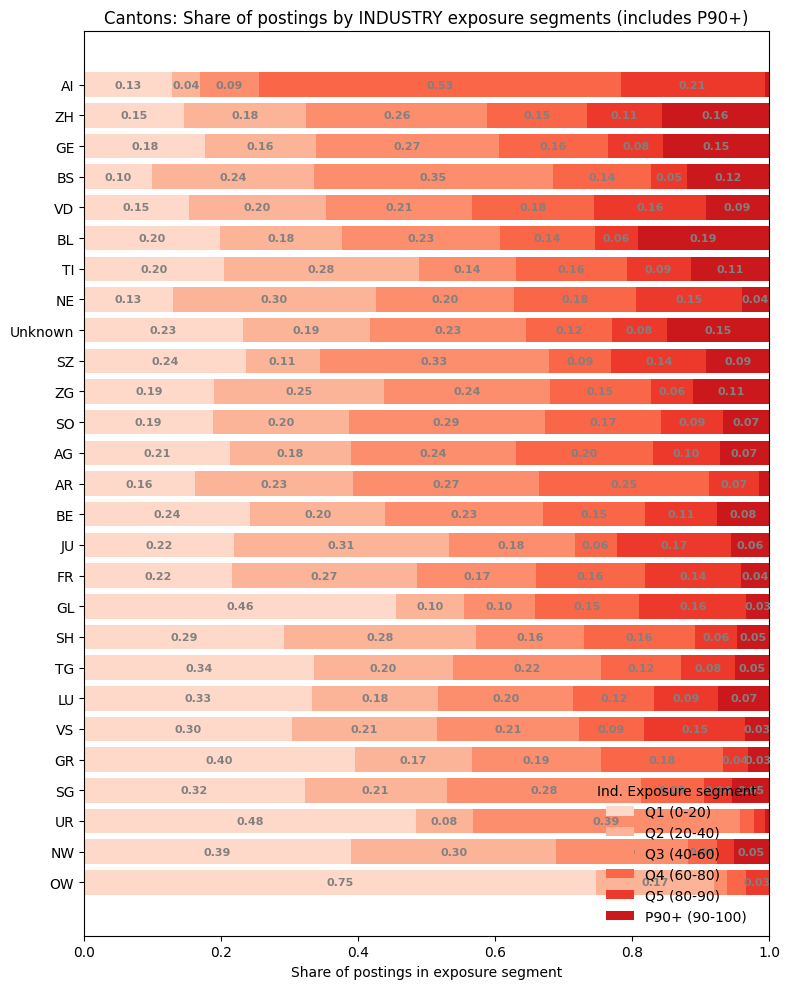

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_kanton_stack_segments_ind_exp.png
Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_region_p80_vs_segments_ind.csv
Max abs diff: 5.551115123125783e-17


,region,p80_share,q5_share,p90_share,q5_p90_share,diff
4,BL,0.258699,0.066924,0.191774,0.258699,5.551115e-17
23,VD,0.269105,0.177150,0.091955,0.269105,5.551115e-17
8,GL,0.190463,0.157382,0.033081,0.190463,5.551115e-17
12,NE,0.200262,0.160498,0.039763,0.200262,5.551115e-17
18,SZ,0.237523,0.146194,0.091329,0.237523,5.551115e-17
22,Unknown,0.243349,0.094552,0.148797,0.243349,2.775558e-17
20,TI,0.227955,0.113561,0.114393,0.227955,-2.775558e-17
10,JU,0.222632,0.167322,0.055310,0.222632,2.775558e-17
19,TG,0.129608,0.079283,0.050325,0.129608,2.775558e-17
1,AI,0.227642,0.221137,0.006504,0.227642,-2.775558e-17


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/3060603006.py:276: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reg_metrics_sec["mean_sec_exp_tru2"] = sec_reg_group.apply(wmean_section_exp)
/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/3060603006.py:285: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  known_denom_sec = sec_reg_group.apply(lambda g: g.loc[g[section_exp_col]

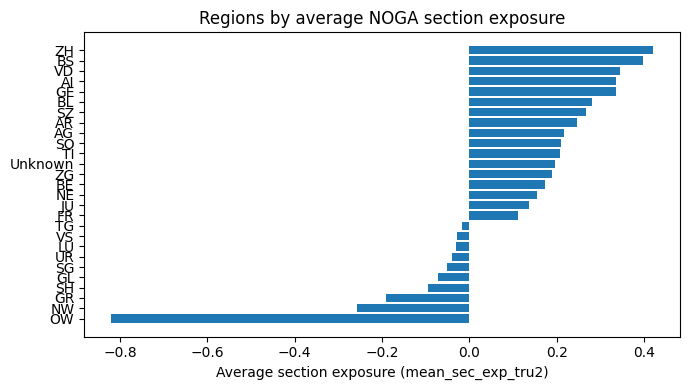

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_canton_top30_avg_section_exposure.png


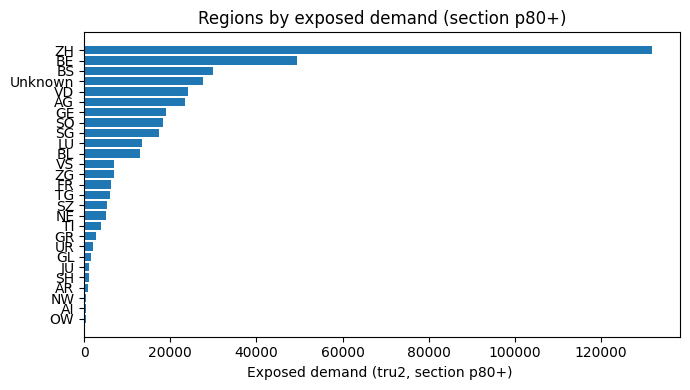

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top15_exposed_p80_sec.png


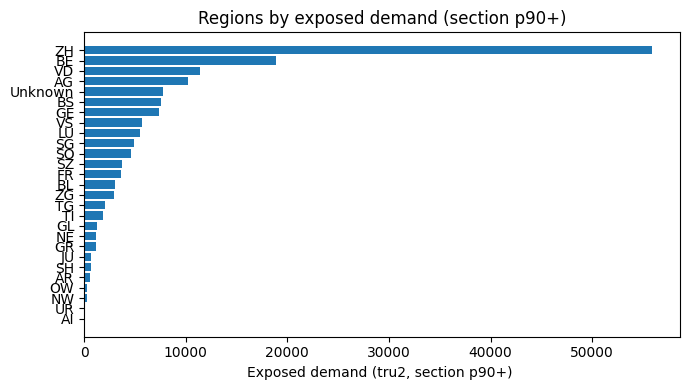

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top15_exposed_p90_sec.png


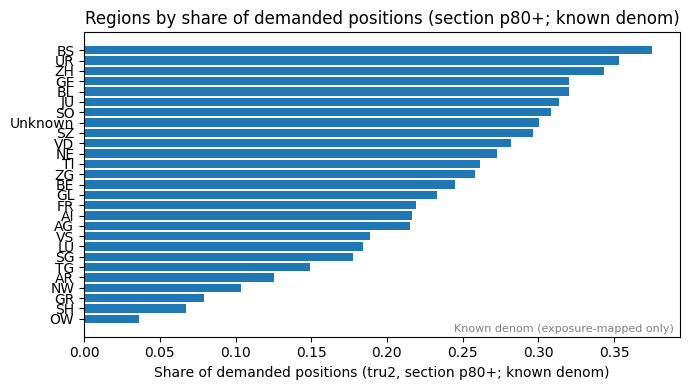

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top30_share_p80_sec.png


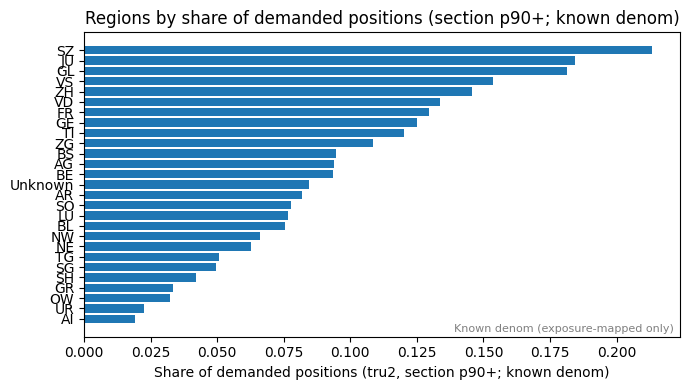

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top30_share_p90_sec.png


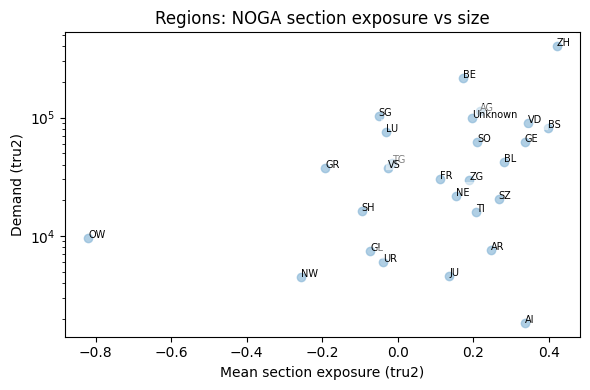

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_scatter_sec.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/3060603006.py:401: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g[section_exp_col].dropna(), weights=g.loc[g[section_exp_col].notna(), "srvy_wght_tru2"])


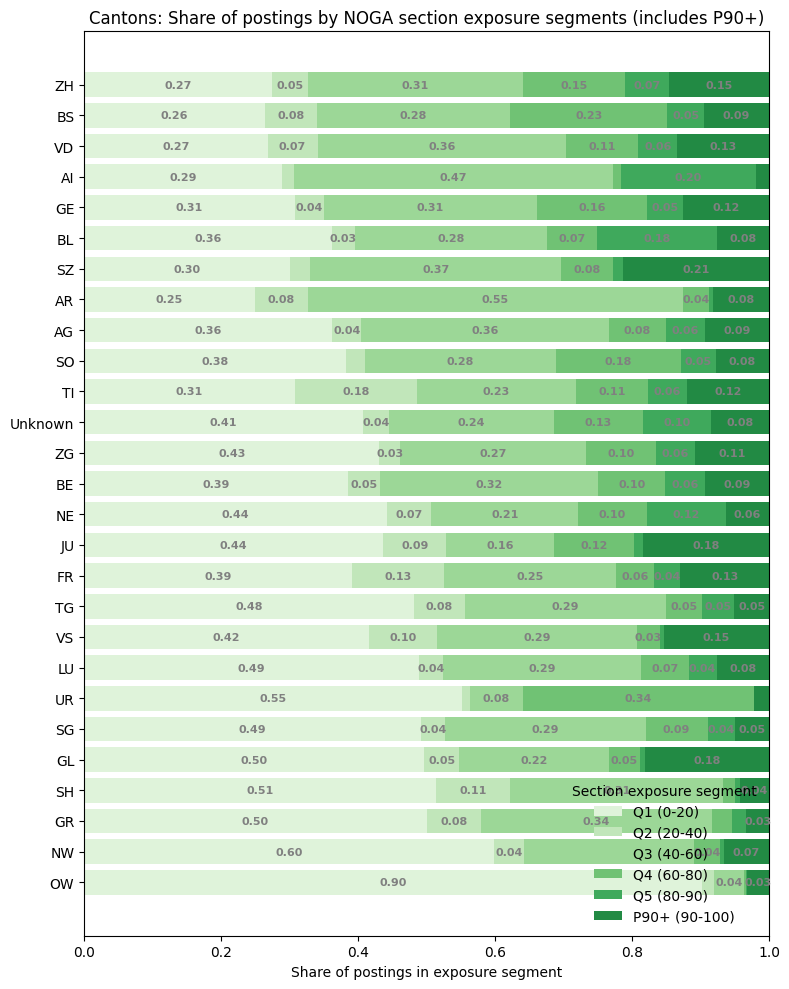

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_kanton_stack_segments_section_exp.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/3060603006.py:441: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(


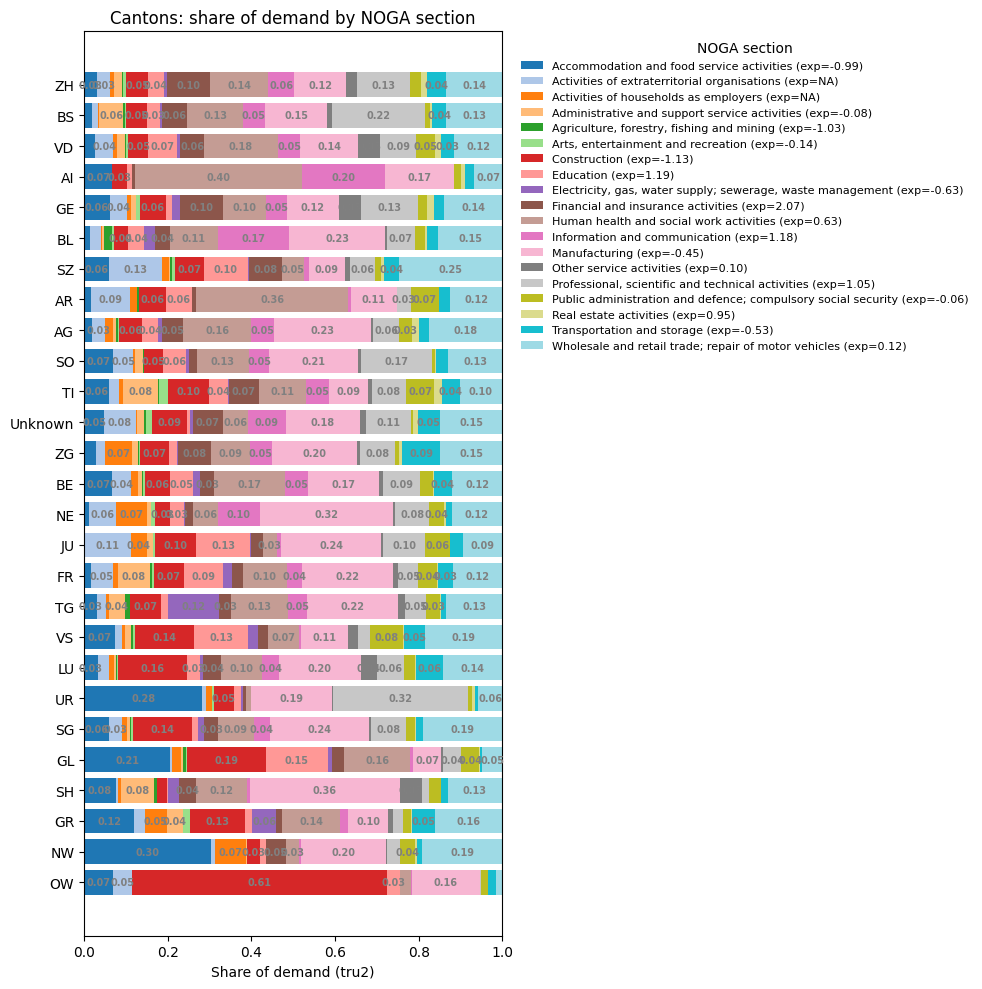

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_kanton_stack_section_share.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/3060603006.py:497: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(


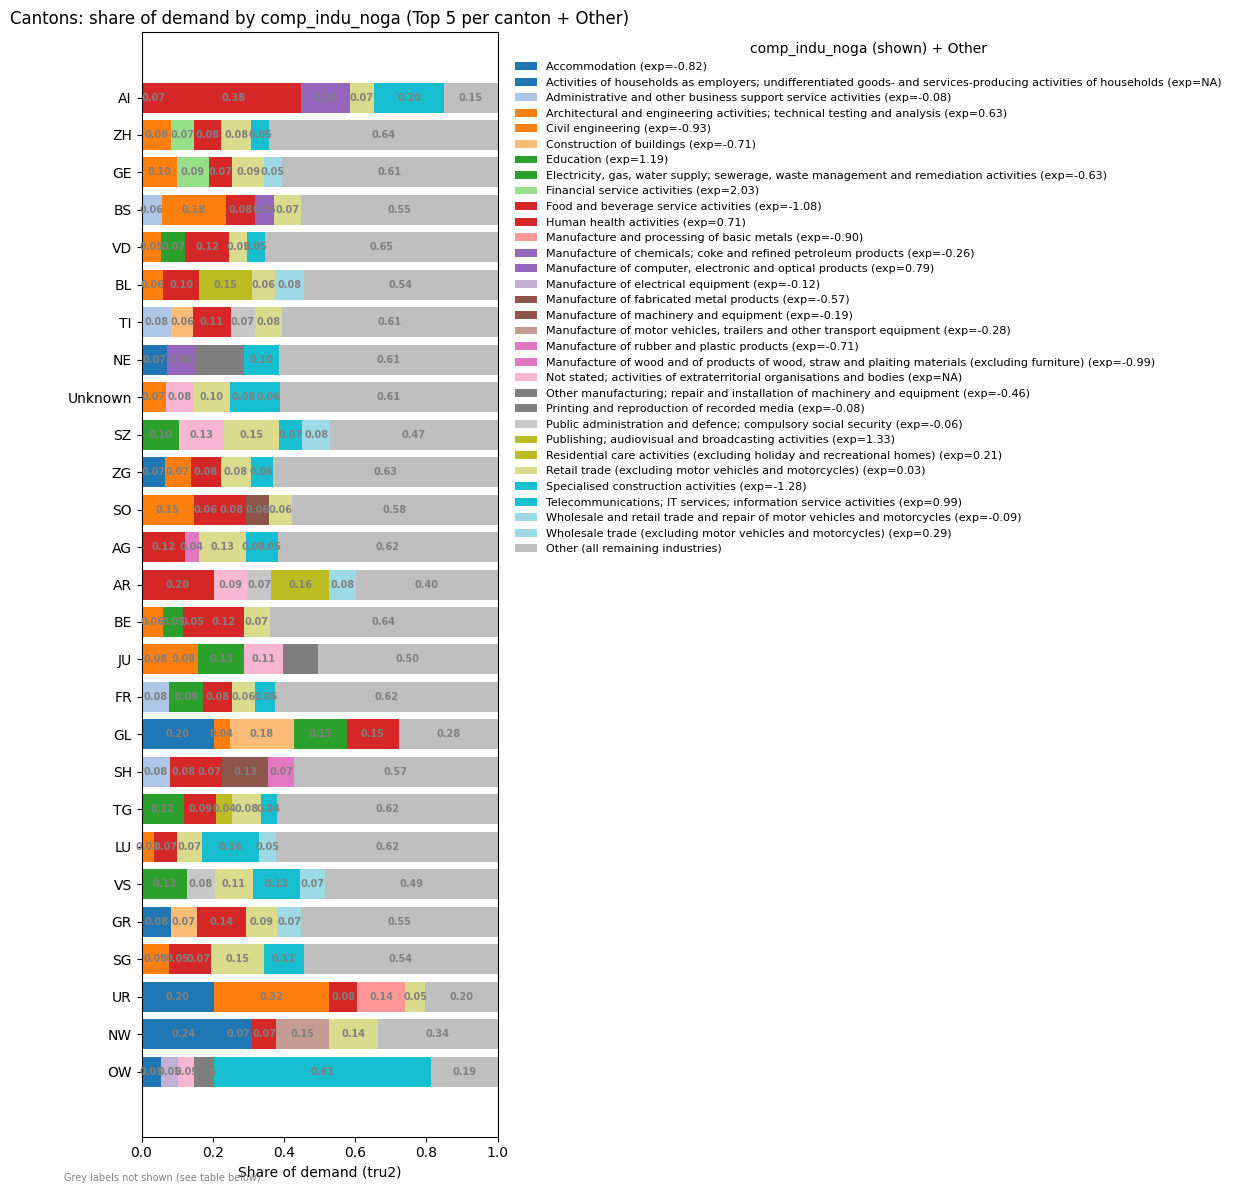

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_kanton_stack_comp_indu_noga_share.png


,_ind_code,_ind_label,note
0,1,"Agriculture, forestry and fishing",Not in top 5 for any canton
1,10,Manufacture of glass and glass products; ceram...,Not in top 5 for any canton
10,2,Manufacture of food products and tobacco products,Not in top 5 for any canton
16,25,Land transport and transport via pipelines,Not in top 5 for any canton
17,26,Water transport and air transport,Not in top 5 for any canton
18,27,Warehousing and support activities for transpo...,Not in top 5 for any canton
19,28,Postal and courier activities,Not in top 5 for any canton
21,3,Manufacture of textiles and wearing apparel,Not in top 5 for any canton
26,34,"Insurance, reinsurance and pension funding (ex...",Not in top 5 for any canton
27,35,Activities auxiliary to financial and insuranc...,Not in top 5 for any canton


Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_region_top5_industry_section.csv


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/3060603006.py:582: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,loca_regi_kant_label,_section_label,demand_tru2,section_exposure_weighted,rank
12,AG,Manufacturing,26627.2432,-0.450426,1.0
18,AG,Wholesale and retail trade; repair of motor ve...,20155.1047,0.120153,2.0
10,AG,Human health and social work activities,18500.4375,0.627138,3.0
14,AG,"Professional, scientific and technical activities",7022.3178,1.047356,4.0
6,AG,Construction,6336.6923,-1.128442,5.0
...,...,...,...,...,...
479,ZH,Human health and social work activities,55916.5321,0.627138,1.0
487,ZH,Wholesale and retail trade; repair of motor ve...,54162.6313,0.120153,2.0
483,ZH,"Professional, scientific and technical activities",50844.5426,1.047356,3.0
481,ZH,Manufacturing,49431.6736,-0.450426,4.0


In [402]:
# ==== Plot: average industry exposure per canton ====
# Compute weighted average industry exposure per canton
def wmean_industry_exp(g):
    x = g.loc[g[ind_exp_col].notna(), ind_exp_col]
    w = g.loc[g[ind_exp_col].notna(), "srvy_wght_tru2"]
    return np.average(x, weights=w) if len(x) else np.nan

indreg_group = _df.groupby(region_col)
avg_ind_exp_by_kanton = indreg_group.apply(wmean_industry_exp).reset_index(name="mean_ind_exp_tru2")

top_kanton_ind_exp = avg_ind_exp_by_kanton.nlargest(30, "mean_ind_exp_tru2")
plt.figure(figsize=(7,4))
plt.barh(top_kanton_ind_exp[region_col].astype(str), top_kanton_ind_exp["mean_ind_exp_tru2"])
plt.gca().invert_yaxis()
plt.xlabel("Average industry exposure (mean_ind_exp_tru2)")
plt.title("Cantons by average industry exposure")
plt.tight_layout()
fig_path = OUT_VIS / "fig_canton_top30_avg_industry_exposure.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)
# ==== End plot ====

# Region summary (industry exposure)
ind_reg_group = _df.groupby(region_col)

reg_metrics_ind = ind_reg_group.agg(
    demand_total_tru2=("srvy_wght_tru2","sum"),
    postings_total_tru1=("srvy_wght_tru1","sum")
)
reg_metrics_ind["mean_ind_exp_tru2"] = ind_reg_group.apply(wmean_industry_exp)

# exposed demand p80/p90 (industry)
reg_metrics_ind["exposed_demand_p80_ind"] = _df.loc[_df[ind_exp_col] >= ind_p80].groupby(region_col)["srvy_wght_tru2"].sum()
reg_metrics_ind["exposed_demand_p90_ind"] = _df.loc[_df[ind_exp_col] >= ind_p90].groupby(region_col)["srvy_wght_tru2"].sum()
reg_metrics_ind = reg_metrics_ind.fillna(0)

# shares
known_denom_ind = ind_reg_group.apply(lambda g: g.loc[g[ind_exp_col].notna(), "srvy_wght_tru2"].sum())
reg_metrics_ind["high_share_total_p80_ind"] = reg_metrics_ind["exposed_demand_p80_ind"] / reg_metrics_ind["demand_total_tru2"]
reg_metrics_ind["high_share_known_p80_ind"] = reg_metrics_ind["exposed_demand_p80_ind"] / known_denom_ind
reg_metrics_ind["coverage_share_ind"] = known_denom_ind / reg_metrics_ind["demand_total_tru2"]

reg_metrics_ind["high_share_total_p90_ind"] = reg_metrics_ind["exposed_demand_p90_ind"] / reg_metrics_ind["demand_total_tru2"]
reg_metrics_ind["high_share_known_p90_ind"] = reg_metrics_ind["exposed_demand_p90_ind"] / known_denom_ind
reg_metrics_ind = reg_metrics_ind.reset_index()
reg_metrics_ind.to_csv(OUT_TABLES / "table_region_summary_industry.csv", index=False)

# Bar charts: exposed demand p80/p90 (industry)
for thresh_label in ["p80","p90"]:
    col = f"exposed_demand_{thresh_label}_ind"
    top_reg = reg_metrics_ind.nlargest(30, col)
    plt.figure(figsize=(7,4))
    plt.barh(top_reg[region_col].astype(str), top_reg[col])
    plt.gca().invert_yaxis()
    plt.xlabel(f"Exposed demand (tru2, industry {thresh_label}+) ")
    plt.title(f"Regions by exposed demand (industry {thresh_label}+)")
    plt.tight_layout()
    fig_path = OUT_VIS / f"fig_region_top15_exposed_{thresh_label}_ind.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Saved", fig_path)

# Bar charts: share of demanded positions (industry)

for thresh_label in ["p80", "p90"]:
    share_col = f"high_share_known_{thresh_label}_ind"
    plot_data = reg_metrics_ind.copy()
    plot_data[region_col] = plot_data[region_col].fillna("Unknown")
    plot_data[share_col] = pd.to_numeric(plot_data[share_col], errors="coerce").fillna(0)
    top_reg_share = plot_data.nlargest(30, share_col)
    plt.figure(figsize=(7,4))
    plt.barh(top_reg_share[region_col].astype(str), top_reg_share[share_col])
    plt.gca().invert_yaxis()
    plt.xlabel(f"Share of demanded positions (tru2, industry {thresh_label}+; known denom)")
    plt.title(f"Regions by share of demanded positions (industry {thresh_label}+; known denom)")
    plt.text(0.99, 0.01, 'Known denom (exposure-mapped only)', transform=plt.gca().transAxes, ha='right', va='bottom', fontsize=8, color='gray')
    plt.tight_layout()
    fig_path = OUT_VIS / f"fig_region_top30_share_{thresh_label}_ind.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Saved", fig_path)





# Scatter (industry)
plt.figure(figsize=(6,4))
plt.scatter(reg_metrics_ind["mean_ind_exp_tru2"], reg_metrics_ind["demand_total_tru2"], alpha=0.7)
label_set = set()
label_set.update(reg_metrics_ind.nlargest(30, "demand_total_tru2")[region_col].tolist())
label_set.update(reg_metrics_ind.nlargest(30, "mean_ind_exp_tru2")[region_col].tolist())
if "Unknown" in reg_metrics_ind[region_col].values:
    label_set.add("Unknown")
for _, row in reg_metrics_ind[reg_metrics_ind[region_col].isin(label_set)].iterrows():
    plt.text(row["mean_ind_exp_tru2"], row["demand_total_tru2"], str(row[region_col]), fontsize=7,
             bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
plt.xlabel("Mean industry exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("Regions: industry exposure vs size")
plt.tight_layout()
fig_path = OUT_VIS / "fig_region_scatter_ind.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Decomposition: top 5 regions by exposed demand (industry p80)
reg_metrics_ind_sorted = reg_metrics_ind.sort_values("exposed_demand_p80_ind", ascending=False)
top_regions_ind = reg_metrics_ind_sorted.head(5)[region_col].tolist()
rows_occ_ind = []
rows_ind_ind = []
if "occ2_label" not in globals():
    occ2_label = _df["occu_isco2_label"].fillna("Unknown")
for reg in top_regions_ind:
    sub = _df[(_df[region_col] == reg) & (_df[ind_exp_col] >= ind_p80)]
    sub_occ = sub.groupby(occ2_label)["srvy_wght_tru2"].sum().sort_values(ascending=False).head(5)
    for rank, (code, val) in enumerate(sub_occ.items(), start=1):
        rows_occ_ind.append({"region": reg, "rank": rank, "occ2_label": code, "exposed_demand_tru2": val})
    sub_ind = sub.groupby(_df["comp_indu_noga_label"].fillna("Unknown"))["srvy_wght_tru2"].sum().sort_values(ascending=False).head(5)
    for rank, (code, val) in enumerate(sub_ind.items(), start=1):
        rows_ind_ind.append({"region": reg, "rank": rank, "indu_label": code, "exposed_demand_tru2": val})

pd.DataFrame(rows_occ_ind).to_csv(OUT_TABLES / "table_region_top_occ2_contrib_ind.csv", index=False)
pd.DataFrame(rows_ind_ind).to_csv(OUT_TABLES / "table_region_top_ind_contrib_ind.csv", index=False)



# === Plot: horizontal stacked bars for exposure segments per canton (INDUSTRY exposure, includes P90+) ===
# Build exposure segments using global p20/p40/p60/p80/p90 thresholds
ind_p20_seg, ind_p40_seg, ind_p60_seg = ind_p20, ind_p40, ind_p60
ind_p80_seg, ind_p90_seg = ind_p80, ind_p90

def _ind_segment(x):
    if pd.isna(x):
        return pd.NA
    if x <= ind_p20:
        return "Q1 (0-20)"
    if x <= ind_p40:
        return "Q2 (20-40)"
    if x <= ind_p60:
        return "Q3 (40-60)"
    if x <= ind_p80_seg:
        return "Q4 (60-80)"
    if x < ind_p90_seg:
        return "Q5 (80-90)"
    return "P90+ (90-100)"

_df["ind_exposure_segment"] = _df[ind_exp_col].apply(_ind_segment)
segments = ["Q1 (0-20)", "Q2 (20-40)", "Q3 (40-60)", "Q4 (60-80)", "Q5 (80-90)", "P90+ (90-100)"]

postings_per_kanton_segment_ind = (
    _df[_df[region_col].notna() & _df["ind_exposure_segment"].notna()]
    .groupby([region_col, "ind_exposure_segment"], observed=True)["srvy_wght_tru2"].sum()
    .unstack(fill_value=0)
)
for seg in segments:
    if seg not in postings_per_kanton_segment_ind.columns:
        postings_per_kanton_segment_ind[seg] = 0

postings_per_kanton_segment_share_ind = postings_per_kanton_segment_ind.div(
    postings_per_kanton_segment_ind.sum(axis=1), axis=0
)
postings_per_kanton_segment_share_ind = postings_per_kanton_segment_share_ind.loc[
    postings_per_kanton_segment_share_ind.sum(axis=1) > 0
]

mean_ind_exposure_by_kanton = (
    _df.groupby(region_col)
    .apply(lambda g: np.average(g[ind_exp_col].dropna(), weights=g.loc[g[ind_exp_col].notna(), "srvy_wght_tru2"])
           if g[ind_exp_col].notna().any() else 0)
)
plot_order_ind = mean_ind_exposure_by_kanton.loc[postings_per_kanton_segment_share_ind.index].sort_values(ascending=True).index.tolist()
postings_per_kanton_segment_share_ind = postings_per_kanton_segment_share_ind.loc[plot_order_ind]

fig, ax = plt.subplots(figsize=(8, 10))

colormap_ind = plt.get_cmap("Reds")
segment_colors = [colormap_ind(0.15 + 0.12*i) for i in range(len(segments))]

bottom = np.zeros(len(postings_per_kanton_segment_share_ind))
y_labels = postings_per_kanton_segment_share_ind.index.astype(str)

for i, seg in enumerate(segments):
    vals = postings_per_kanton_segment_share_ind[seg].values
    bars = ax.barh(
        y_labels,
        vals,
        left=bottom,
        height=0.8,
        color=segment_colors[i],
        label=seg
    )
    for j, (bar, share) in enumerate(zip(bars, vals)):
        if np.isfinite(share) and share >= 0.03:
            xpos = bottom[j] + share/2
            ypos = bar.get_y() + bar.get_height()/2
            ax.text(
                xpos,
                ypos,
                f"{share:.2f}",
                ha="center",
                va="center",
                color="grey",
                fontsize=8,
                fontweight="bold"
            )
    bottom += vals

ax.set_xlabel("Share of postings in exposure segment")
ax.set_title("Cantons: Share of postings by INDUSTRY exposure segments (includes P90+)")
ax.set_xlim(0, 1)
ax.legend(title="Ind. Exposure segment", loc="lower right", frameon=False)
plt.tight_layout()

fig_path = OUT_VIS / "fig_kanton_stack_segments_ind_exp.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


# --- Diagnostic: p80 share vs (Q5 + P90+) per region (industry) ---
rows = []
for reg, g in _df.groupby(region_col):
    g = g[g[ind_exp_col].notna()]
    denom = g["srvy_wght_tru2"].sum()
    if denom == 0:
        continue
    p80_share = g.loc[g[ind_exp_col] >= ind_p80, "srvy_wght_tru2"].sum() / denom
    q5_share = g.loc[(g[ind_exp_col] >= ind_p80) & (g[ind_exp_col] < ind_p90), "srvy_wght_tru2"].sum() / denom
    p90_share = g.loc[g[ind_exp_col] >= ind_p90, "srvy_wght_tru2"].sum() / denom
    rows.append({
        "region": reg,
        "p80_share": p80_share,
        "q5_share": q5_share,
        "p90_share": p90_share,
        "q5_p90_share": q5_share + p90_share,
        "diff": p80_share - (q5_share + p90_share),
    })

diag = pd.DataFrame(rows)
diag.to_csv(OUT_TABLES / "table_region_p80_vs_segments_ind.csv", index=False)
print("Saved", OUT_TABLES / "table_region_p80_vs_segments_ind.csv")
print("Max abs diff:", diag["diff"].abs().max())
# show biggest differences (should be ~0 if consistent)
display(diag.sort_values("diff", key=lambda s: s.abs(), ascending=False).head(10))






# === NOGA section exposure plots (regions) ===
section_exp_col = "industry_section_exposure_weighted"

# thresholds (weighted)
sec_p80 = weighted_quantile(_df[section_exp_col], _df["srvy_wght_tru2"], 0.80)
sec_p90 = weighted_quantile(_df[section_exp_col], _df["srvy_wght_tru2"], 0.90)
sec_p20 = weighted_quantile(_df[section_exp_col], _df["srvy_wght_tru2"], 0.20)
sec_p40 = weighted_quantile(_df[section_exp_col], _df["srvy_wght_tru2"], 0.40)
sec_p60 = weighted_quantile(_df[section_exp_col], _df["srvy_wght_tru2"], 0.60)

# Region summary (section exposure)
sec_reg_group = _df.groupby(region_col)

def wmean_section_exp(g):
    x = g.loc[g[section_exp_col].notna(), section_exp_col]
    w = g.loc[g[section_exp_col].notna(), "srvy_wght_tru2"]
    return np.average(x, weights=w) if len(x) else np.nan

reg_metrics_sec = sec_reg_group.agg(
    demand_total_tru2=("srvy_wght_tru2","sum"),
    postings_total_tru1=("srvy_wght_tru1","sum")
)
reg_metrics_sec["mean_sec_exp_tru2"] = sec_reg_group.apply(wmean_section_exp)

# exposed demand p80/p90 (section)
exposed_p80_sec = _df.loc[_df[section_exp_col] >= sec_p80].groupby(region_col)["srvy_wght_tru2"].sum()
exposed_p90_sec = _df.loc[_df[section_exp_col] >= sec_p90].groupby(region_col)["srvy_wght_tru2"].sum()
reg_metrics_sec["exposed_demand_p80_sec"] = reg_metrics_sec.index.map(exposed_p80_sec).fillna(0)
reg_metrics_sec["exposed_demand_p90_sec"] = reg_metrics_sec.index.map(exposed_p90_sec).fillna(0)

# shares
known_denom_sec = sec_reg_group.apply(lambda g: g.loc[g[section_exp_col].notna(), "srvy_wght_tru2"].sum())
reg_metrics_sec["high_share_known_p80_sec"] = reg_metrics_sec["exposed_demand_p80_sec"] / reg_metrics_sec.index.map(known_denom_sec)
reg_metrics_sec["high_share_known_p90_sec"] = reg_metrics_sec["exposed_demand_p90_sec"] / reg_metrics_sec.index.map(known_denom_sec)
reg_metrics_sec["coverage_share_sec"] = reg_metrics_sec.index.map(known_denom_sec) / reg_metrics_sec["demand_total_tru2"]

reg_metrics_sec = reg_metrics_sec.reset_index()
reg_metrics_sec.to_csv(OUT_TABLES / "table_region_summary_ind_section.csv", index=False)

# Bar: average section exposure
sec_avg = reg_metrics_sec.nlargest(30, "mean_sec_exp_tru2")
plt.figure(figsize=(7,4))
plt.barh(sec_avg[region_col].astype(str), sec_avg["mean_sec_exp_tru2"])
plt.gca().invert_yaxis()
plt.xlabel("Average section exposure (mean_sec_exp_tru2)")
plt.title("Regions by average NOGA section exposure")
plt.tight_layout()
fig_path = OUT_VIS / "fig_canton_top30_avg_section_exposure.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Bar: exposed demand p80/p90 (section)
for thresh_label in ["p80","p90"]:
    col = f"exposed_demand_{thresh_label}_sec"
    top_reg = reg_metrics_sec.nlargest(30, col)
    plt.figure(figsize=(7,4))
    plt.barh(top_reg[region_col].astype(str), top_reg[col])
    plt.gca().invert_yaxis()
    plt.xlabel(f"Exposed demand (tru2, section {thresh_label}+) ")
    plt.title(f"Regions by exposed demand (section {thresh_label}+)")
    plt.tight_layout()
    fig_path = OUT_VIS / f"fig_region_top15_exposed_{thresh_label}_sec.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Saved", fig_path)

# Bar: share of demanded positions (section)
for thresh_label in ["p80", "p90"]:
    share_col = f"high_share_known_{thresh_label}_sec"
    plot_data = reg_metrics_sec.copy()
    plot_data[region_col] = plot_data[region_col].fillna("Unknown")
    plot_data[share_col] = pd.to_numeric(plot_data[share_col], errors="coerce").fillna(0)
    top_reg_share = plot_data.nlargest(30, share_col)
    plt.figure(figsize=(7,4))
    plt.barh(top_reg_share[region_col].astype(str), top_reg_share[share_col])
    plt.gca().invert_yaxis()
    plt.xlabel(f"Share of demanded positions (tru2, section {thresh_label}+; known denom)")
    plt.title(f"Regions by share of demanded positions (section {thresh_label}+; known denom)")
    plt.text(0.99, 0.01, 'Known denom (exposure-mapped only)', transform=plt.gca().transAxes, ha='right', va='bottom', fontsize=8, color='gray')
    plt.tight_layout()
    fig_path = OUT_VIS / f"fig_region_top30_share_{thresh_label}_sec.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Saved", fig_path)

# Scatter (section)
plt.figure(figsize=(6,4))
plt.scatter(reg_metrics_sec["mean_sec_exp_tru2"], reg_metrics_sec["demand_total_tru2"], alpha=0.7)
label_set = set()
label_set.update(reg_metrics_sec.nlargest(30, "demand_total_tru2")[region_col].tolist())
label_set.update(reg_metrics_sec.nlargest(30, "mean_sec_exp_tru2")[region_col].tolist())
if "Unknown" in reg_metrics_sec[region_col].values:
    label_set.add("Unknown")
for _, row in reg_metrics_sec[reg_metrics_sec[region_col].isin(label_set)].iterrows():
    plt.text(row["mean_sec_exp_tru2"], row["demand_total_tru2"], str(row[region_col]), fontsize=7,
             bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
plt.xlabel("Mean section exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("Regions: NOGA section exposure vs size")
plt.tight_layout()
fig_path = OUT_VIS / "fig_region_scatter_sec.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Stacked segments (section) including P90+
sec_p20_seg, sec_p40_seg, sec_p60_seg = sec_p20, sec_p40, sec_p60
sec_p80_seg, sec_p90_seg = sec_p80, sec_p90

def _sec_segment(x):
    if pd.isna(x):
        return pd.NA
    if x <= sec_p20_seg:
        return "Q1 (0-20)"
    if x <= sec_p40_seg:
        return "Q2 (20-40)"
    if x <= sec_p60_seg:
        return "Q3 (40-60)"
    if x <= sec_p80_seg:
        return "Q4 (60-80)"
    if x < sec_p90_seg:
        return "Q5 (80-90)"
    return "P90+ (90-100)"

_df["sec_exposure_segment"] = _df[section_exp_col].apply(_sec_segment)
sec_segments = ["Q1 (0-20)", "Q2 (20-40)", "Q3 (40-60)", "Q4 (60-80)", "Q5 (80-90)", "P90+ (90-100)"]

postings_per_kanton_segment_sec = (
    _df[_df[region_col].notna() & _df["sec_exposure_segment"].notna()]
    .groupby([region_col, "sec_exposure_segment"], observed=True)["srvy_wght_tru2"].sum()
    .unstack(fill_value=0)
)
for seg in sec_segments:
    if seg not in postings_per_kanton_segment_sec.columns:
        postings_per_kanton_segment_sec[seg] = 0

postings_per_kanton_segment_share_sec = postings_per_kanton_segment_sec.div(
    postings_per_kanton_segment_sec.sum(axis=1), axis=0
)
postings_per_kanton_segment_share_sec = postings_per_kanton_segment_share_sec.loc[
    postings_per_kanton_segment_share_sec.sum(axis=1) > 0
]

mean_sec_exposure_by_kanton = (
    _df.groupby(region_col)
    .apply(lambda g: np.average(g[section_exp_col].dropna(), weights=g.loc[g[section_exp_col].notna(), "srvy_wght_tru2"])
           if g[section_exp_col].notna().any() else 0)
)
plot_order_sec = mean_sec_exposure_by_kanton.loc[postings_per_kanton_segment_share_sec.index].sort_values(ascending=True).index.tolist()
postings_per_kanton_segment_share_sec = postings_per_kanton_segment_share_sec.loc[plot_order_sec]

fig, ax = plt.subplots(figsize=(8, 10))
colormap_sec = plt.get_cmap("Greens")
seg_colors = [colormap_sec(0.15 + 0.12*i) for i in range(len(sec_segments))]

bottom = np.zeros(len(postings_per_kanton_segment_share_sec))
y_labels = postings_per_kanton_segment_share_sec.index.astype(str)

for i, seg in enumerate(sec_segments):
    vals = postings_per_kanton_segment_share_sec[seg].values
    bars = ax.barh(y_labels, vals, left=bottom, height=0.8, color=seg_colors[i], label=seg)
    for j, (bar, share) in enumerate(zip(bars, vals)):
        if np.isfinite(share) and share >= 0.03:
            xpos = bottom[j] + share/2
            ypos = bar.get_y() + bar.get_height()/2
            ax.text(xpos, ypos, f"{share:.2f}", ha="center", va="center", color="grey", fontsize=8, fontweight="bold")
    bottom += vals

ax.set_xlabel("Share of postings in exposure segment")
ax.set_title("Cantons: Share of postings by NOGA section exposure segments (includes P90+)")
ax.set_xlim(0, 1)
ax.legend(title="Section exposure segment", loc="lower right", frameon=False)
plt.tight_layout()
fig_path = OUT_VIS / "fig_kanton_stack_segments_section_exp.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


# === Plot: share of demand by NOGA section (stacked bars) ===
section_label = _df["industry_section_label"].fillna("Unknown")

sec_exp_map = (
    _df.assign(_sec=section_label)
       .groupby("_sec", observed=True)
       .apply(lambda g: np.average(
           g.loc[g["industry_section_exposure_weighted"].notna(), "industry_section_exposure_weighted"],
           weights=g.loc[g["industry_section_exposure_weighted"].notna(), "srvy_wght_tru2"]
       ) if g["industry_section_exposure_weighted"].notna().any() else np.nan)
)
section_label_exp = section_label.map(lambda lab: f"{lab} (exp={sec_exp_map.get(lab, float('nan')):.2f})" if pd.notna(sec_exp_map.get(lab, np.nan)) else f"{lab} (exp=NA)")

section_by_kanton = (
    _df[_df[region_col].notna()]
      .assign(_section=section_label_exp)
      .groupby([region_col, "_section"], observed=True)["srvy_wght_tru2"].sum()
      .unstack(fill_value=0)
)

section_share = section_by_kanton.div(section_by_kanton.sum(axis=1), axis=0)
section_share = section_share.loc[section_share.sum(axis=1) > 0]

# Order by section exposure mean if available
try:
    section_share = section_share.loc[plot_order_sec]
except Exception:
    pass

fig, ax = plt.subplots(figsize=(10, 10))
labels = section_share.index.astype(str)
category_cols = section_share.columns.tolist()
cmap = plt.get_cmap("tab20", len(category_cols))
colors = [cmap(i) for i in range(len(category_cols))]

bottom = np.zeros(len(section_share))
for i, cat in enumerate(category_cols):
    vals = section_share[cat].values
    bars = ax.barh(labels, vals, left=bottom, height=0.8, color=colors[i], label=cat)
    for j, (bar, share) in enumerate(zip(bars, vals)):
        if np.isfinite(share) and share >= 0.03:
            ax.text(bottom[j] + share/2, bar.get_y() + bar.get_height()/2, f"{share:.2f}",
                    ha="center", va="center", color="grey", fontsize=7, fontweight="bold")
    bottom += vals

ax.set_xlabel("Share of demand (tru2)")
ax.set_title("Cantons: share of demand by NOGA section")
ax.set_xlim(0, 1)
ax.legend(title="NOGA section", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False, fontsize=8)
plt.tight_layout()
fig_path = OUT_VIS / "fig_kanton_stack_section_share.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# === Plot: share of demand by comp_indu_noga (Top 5 per canton + Other) ===
ind_code = _df["comp_indu_noga"].astype("string")
ind_label = _df["comp_indu_noga_label"].fillna("Unknown")

ind_exp_map = (
    _df.assign(_ind=ind_label)
       .groupby("_ind", observed=True)
       .apply(lambda g: np.average(
           g.loc[g[ind_exp_col].notna(), ind_exp_col],
           weights=g.loc[g[ind_exp_col].notna(), "srvy_wght_tru2"]
       ) if g[ind_exp_col].notna().any() else np.nan)
)
ind_label_exp = ind_label.map(lambda lab: f"{lab} (exp={ind_exp_map.get(lab, float('nan')):.2f})" if pd.notna(ind_exp_map.get(lab, np.nan)) else f"{lab} (exp=NA)")

ind_demand = (
    _df[_df[region_col].notna()]
      .assign(_ind_code=ind_code, _ind_label=ind_label, _ind_label_exp=ind_label_exp)
      .groupby([region_col, "_ind_code", "_ind_label", "_ind_label_exp"], observed=True)["srvy_wght_tru2"].sum()
      .reset_index()
)

# Total per canton
canton_totals = ind_demand.groupby(region_col)["srvy_wght_tru2"].sum().rename("total").reset_index()
ind_demand = ind_demand.merge(canton_totals, on=region_col, how="left")
ind_demand["share"] = ind_demand["srvy_wght_tru2"] / ind_demand["total"]

# Top 5 per canton
ind_demand["rank"] = ind_demand.groupby(region_col)["share"].rank(method="first", ascending=False)
ind_top = ind_demand[ind_demand["rank"] <= 5].copy()

# Build wide table (top5 per canton + other)
ind_pivot = ind_top.pivot_table(index=region_col, columns="_ind_label_exp", values="share", fill_value=0)

# Other share per canton
other_share = ind_demand[ind_demand["rank"] > 5].groupby(region_col)["share"].sum()
ind_pivot["Other (all remaining industries)"] = other_share
ind_pivot = ind_pivot.fillna(0)

try:
    ind_pivot = ind_pivot.loc[plot_order_ind]
except Exception:
    pass

# Colors: distinct for labels shown at least once; grey for Other
shown_labels = [c for c in ind_pivot.columns if c != "Other (all remaining industries)"]

cmap = plt.get_cmap("tab20", len(shown_labels))
color_map = {lab: cmap(i) for i, lab in enumerate(shown_labels)}
color_map["Other (all remaining industries)"] = (0.75, 0.75, 0.75, 1.0)

fig, ax = plt.subplots(figsize=(12, 12))
labels = ind_pivot.index.astype(str)
category_cols = ind_pivot.columns.tolist()

bottom = np.zeros(len(ind_pivot))
for cat in category_cols:
    vals = ind_pivot[cat].values
    bars = ax.barh(labels, vals, left=bottom, height=0.8, color=color_map[cat], label=cat)
    for j, (bar, share) in enumerate(zip(bars, vals)):
        if np.isfinite(share) and share >= 0.03:
            ax.text(bottom[j] + share/2, bar.get_y() + bar.get_height()/2, f"{share:.2f}",
                    ha="center", va="center", color="grey", fontsize=7, fontweight="bold")
    bottom += vals

ax.set_xlabel("Share of demand (tru2)")
ax.set_title("Cantons: share of demand by comp_indu_noga (Top 5 per canton + Other)")
ax.set_xlim(0, 1)
ax.legend(title="comp_indu_noga (shown) + Other", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False, fontsize=8)

# List labels never shown in top5
all_labels = ind_demand[["_ind_code", "_ind_label"]].drop_duplicates()
shown_codes = ind_top[["_ind_code", "_ind_label"]].drop_duplicates()
not_shown = all_labels.merge(shown_codes, on=["_ind_code", "_ind_label"], how="left", indicator=True)
not_shown = not_shown[not_shown["_merge"] == "left_only"].drop(columns=["_merge"]).sort_values("_ind_code")
not_shown["note"] = "Not in top 5 for any canton"

if not_shown.shape[0] > 0:
    fig.text(0.01, 0.01, "Grey labels not shown (see table below).", fontsize=7, color="grey", ha="left", va="bottom")

plt.tight_layout()
fig_path = OUT_VIS / "fig_kanton_stack_comp_indu_noga_share.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

display(not_shown)
# Top 5 industry sections by canton (show all cantons)
section_label_col = _df["industry_section_label"].fillna(_df["industry_section"]).fillna("Unknown")

section_group = (
    _df.assign(_section_label=section_label_col)
       .groupby([region_col, "_section_label"], observed=True)
       .apply(lambda g: pd.Series({
           "demand_tru2": g["srvy_wght_tru2"].sum(),
           "section_exposure_weighted": (
               np.average(g.loc[g["industry_section_exposure_weighted"].notna(), "industry_section_exposure_weighted"],
                          weights=g.loc[g["industry_section_exposure_weighted"].notna(), "srvy_wght_tru2"])
               if g["industry_section_exposure_weighted"].notna().any() else np.nan
           )
       }))
       .reset_index()
)

section_group["rank"] = section_group.groupby(region_col)["demand_tru2"].rank(method="first", ascending=False)
section_top5 = section_group[section_group["rank"] <= 5].copy()
section_top5 = section_top5.sort_values([region_col, "rank"])

section_top5.to_csv(OUT_TABLES / "table_region_top5_industry_section.csv", index=False)
print("Saved", OUT_TABLES / "table_region_top5_industry_section.csv")

# Show all rows (top 5 per canton)
display(section_top5)

## 7) Trends (annual + rolling + binned)

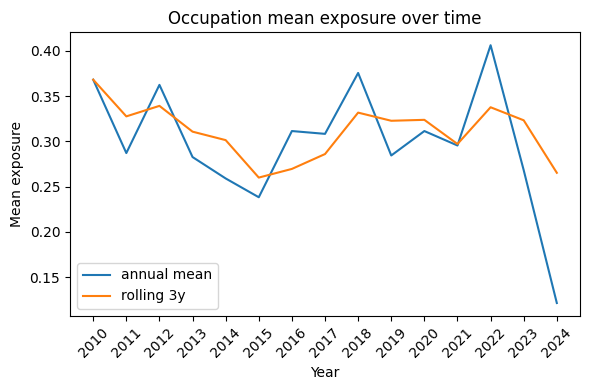

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_trend_occ_allviews.png


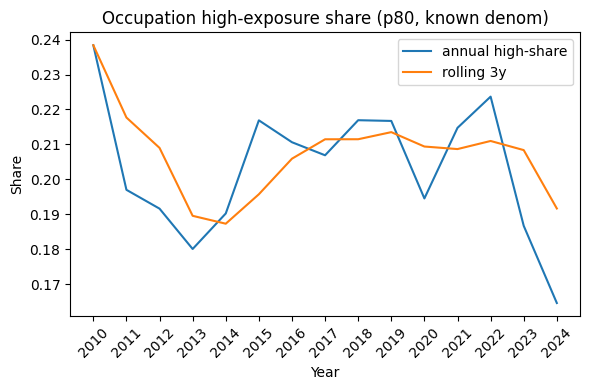

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_trend_occ_allviews_share.png


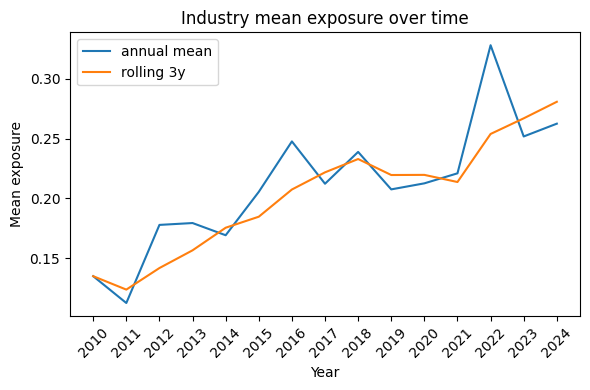

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_trend_ind_allviews.png


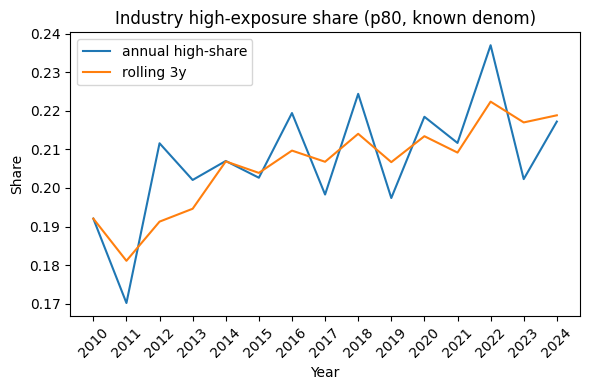

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_trend_ind_allviews_share.png


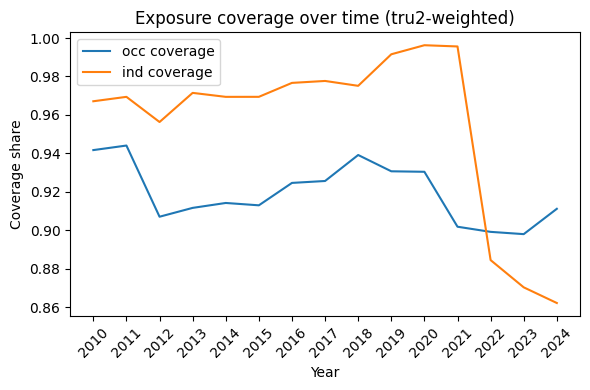

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_coverage_over_time.png


In [403]:
# Annual series
rows = []
for yr, g in _df.groupby('adve_time_year'):
    tot_tru2 = g['srvy_wght_tru2'].sum()
    occ_known = g[occ_exp_col].notna()
    ind_known = g[ind_exp_col].notna()
    row = {
        'year': int(yr),
        'occ_mean_exp': np.average(g.loc[occ_known, occ_exp_col], weights=g.loc[occ_known, 'srvy_wght_tru2']) if occ_known.any() else np.nan,
        'ind_mean_exp': np.average(g.loc[ind_known, ind_exp_col], weights=g.loc[ind_known, 'srvy_wght_tru2']) if ind_known.any() else np.nan,
        'occ_high_share_p80': g.loc[occ_known & (g[occ_exp_col] >= occ_p80), 'srvy_wght_tru2'].sum() / g.loc[occ_known, 'srvy_wght_tru2'].sum() if occ_known.any() else np.nan,
        'ind_high_share_p80': g.loc[ind_known & (g[ind_exp_col] >= ind_p80), 'srvy_wght_tru2'].sum() / g.loc[ind_known, 'srvy_wght_tru2'].sum() if ind_known.any() else np.nan,
        'occ_coverage': g.loc[occ_known, 'srvy_wght_tru2'].sum() / tot_tru2 if tot_tru2 else np.nan,
        'ind_coverage': g.loc[ind_known, 'srvy_wght_tru2'].sum() / tot_tru2 if tot_tru2 else np.nan,
    }
    rows.append(row)
trend_annual = pd.DataFrame(rows).sort_values('year')
trend_annual.to_csv(OUT_TABLES / "table_trends_annual.csv", index=False)

# Rolling 3y
trend_roll = trend_annual.set_index('year').rolling(window=3, min_periods=1).mean().reset_index()
trend_roll.to_csv(OUT_TABLES / "table_trends_rolling3y.csv", index=False)

# Plots: occ
plt.figure(figsize=(6,4))
plt.plot(trend_annual['year'], trend_annual['occ_mean_exp'], label='annual mean')
plt.plot(trend_roll['year'], trend_roll['occ_mean_exp'], label='rolling 3y')
plt.title('Occupation mean exposure over time')
plt.xlabel('Year')
plt.ylabel('Mean exposure')
plt.legend()
plt.xticks(trend_annual['year'], rotation=45)
plt.tight_layout()
fig_path = OUT_VIS / "fig_trend_occ_allviews.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)

plt.figure(figsize=(6,4))
plt.plot(trend_annual['year'], trend_annual['occ_high_share_p80'], label='annual high-share')
plt.plot(trend_roll['year'], trend_roll['occ_high_share_p80'], label='rolling 3y')
plt.title('Occupation high-exposure share (p80, known denom)')
plt.xlabel('Year')
plt.ylabel('Share')
plt.legend()
plt.xticks(trend_annual['year'], rotation=45)
plt.tight_layout()
fig_path = OUT_VIS / "fig_trend_occ_allviews_share.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)

# Plots: ind
plt.figure(figsize=(6,4))
plt.plot(trend_annual['year'], trend_annual['ind_mean_exp'], label='annual mean')
plt.plot(trend_roll['year'], trend_roll['ind_mean_exp'], label='rolling 3y')
plt.title('Industry mean exposure over time')
plt.xlabel('Year')
plt.ylabel('Mean exposure')
plt.legend()
plt.xticks(trend_annual['year'], rotation=45)
plt.tight_layout()
fig_path = OUT_VIS / "fig_trend_ind_allviews.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)

plt.figure(figsize=(6,4))
plt.plot(trend_annual['year'], trend_annual['ind_high_share_p80'], label='annual high-share')
plt.plot(trend_roll['year'], trend_roll['ind_high_share_p80'], label='rolling 3y')
plt.title('Industry high-exposure share (p80, known denom)')
plt.xlabel('Year')
plt.ylabel('Share')
plt.legend()
plt.xticks(trend_annual['year'], rotation=45)
plt.tight_layout()
fig_path = OUT_VIS / "fig_trend_ind_allviews_share.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)

# Coverage over time
plt.figure(figsize=(6,4))
plt.plot(trend_annual['year'], trend_annual['occ_coverage'], label='occ coverage')
plt.plot(trend_annual['year'], trend_annual['ind_coverage'], label='ind coverage')
plt.title('Exposure coverage over time (tru2-weighted)')
plt.xlabel('Year')
plt.ylabel('Coverage share')
plt.legend()
plt.xticks(trend_annual['year'], rotation=45)
plt.tight_layout()
fig_path = OUT_VIS / "fig_coverage_over_time.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)



## 8) Industry vs occupation exposure (correlation + bubble)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


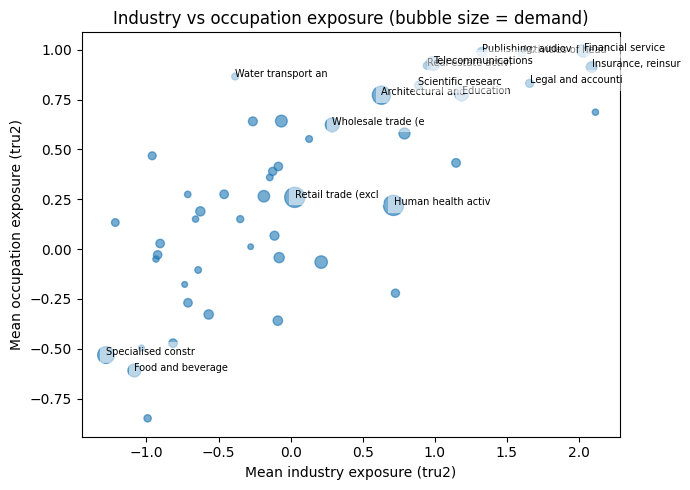

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_ind_vs_occ_exposure_bubble.png
Pearson: 0.7389407993948134
Spearman: 0.7388775510204082
Weighted Pearson: 0.8005239884029244


In [404]:
# Industry-level mix
ind_mix = _df.groupby(_df["comp_indu_noga_label"].fillna("Unknown")).apply(
    lambda g: pd.Series({
        "demand_total_tru2": g["srvy_wght_tru2"].sum(),
        "mean_ind_exp": np.average(g[ind_exp_col].dropna(), weights=g.loc[g[ind_exp_col].notna(),"srvy_wght_tru2"]) if g[ind_exp_col].notna().any() else np.nan,
        "mean_occ_exp": np.average(g[occ_exp_col].dropna(), weights=g.loc[g[occ_exp_col].notna(),"srvy_wght_tru2"]) if g[occ_exp_col].notna().any() else np.nan,
        "share_high_occ_p80": g.loc[g[occ_exp_col] >= occ_p80, "srvy_wght_tru2"].sum() / g["srvy_wght_tru2"].sum(),
        "coverage": g[occ_exp_col].notna().mean(),
    })
).reset_index().rename(columns={"comp_indu_noga_label":"indu_label"})

ind_mix.to_csv(OUT_TABLES / "table_ind_occ_mix.csv", index=False)

# Bubble scatter
plt.figure(figsize=(7,5))
plt.scatter(ind_mix["mean_ind_exp"], ind_mix["mean_occ_exp"], s=(ind_mix["demand_total_tru2"] / ind_mix["demand_total_tru2"].max())*200+10, alpha=0.6)
label_set = set()
label_set.update(ind_mix.nlargest(10, "demand_total_tru2")["indu_label"].tolist())
label_set.update(ind_mix.nlargest(10, "mean_occ_exp")["indu_label"].tolist())
for _, row in ind_mix[ind_mix["indu_label"].isin(label_set)].iterrows():
    plt.text(row["mean_ind_exp"], row["mean_occ_exp"], str(row["indu_label"])[:18], fontsize=7,
             bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
plt.xlabel("Mean industry exposure (tru2)")
plt.ylabel("Mean occupation exposure (tru2)")
plt.title("Industry vs occupation exposure (bubble size = demand)")
plt.tight_layout()
fig_path = OUT_VIS / "fig_ind_vs_occ_exposure_bubble.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)

# Correlations (unweighted + weighted)
valid = ind_mix.dropna(subset=["mean_ind_exp", "mean_occ_exp"])
pearson = valid[["mean_ind_exp","mean_occ_exp"]].corr().iloc[0,1]
# Spearman
spearman = valid[["mean_ind_exp","mean_occ_exp"]].corr(method="spearman").iloc[0,1]

# Weighted Pearson
w = valid["demand_total_tru2"].to_numpy()
xi = valid["mean_ind_exp"].to_numpy()
yi = valid["mean_occ_exp"].to_numpy()
wmx = np.average(xi, weights=w)
wmy = np.average(yi, weights=w)
wcov = np.average((xi-wmx)*(yi-wmy), weights=w)
wsx = np.sqrt(np.average((xi-wmx)**2, weights=w))
wsy = np.sqrt(np.average((yi-wmy)**2, weights=w))
weighted_pearson = wcov / (wsx*wsy) if wsx>0 and wsy>0 else np.nan

print("Pearson:", pearson)
print("Spearman:", spearman)
print("Weighted Pearson:", weighted_pearson)


## 9) Avg demand per posting by exposure decile

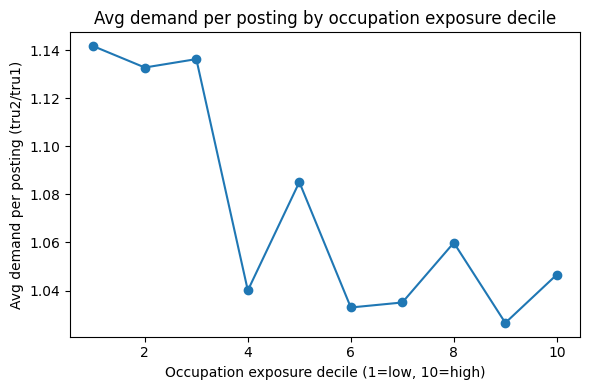

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_avg_demand_per_posting_by_decile.png


In [405]:
# Deciles on occupation exposure (unweighted)
occ_nonmiss = _df[_df[occ_exp_col].notna()].copy()
occ_nonmiss["occ_decile"] = pd.qcut(occ_nonmiss[occ_exp_col], 10, labels=False) + 1

occ_dec = occ_nonmiss.groupby("occ_decile").agg(
    demand_tru2=("srvy_wght_tru2","sum"),
    postings_tru1=("srvy_wght_tru1","sum")
).reset_index()
occ_dec["avg_demand_per_posting"] = occ_dec["demand_tru2"] / occ_dec["postings_tru1"]
occ_dec.to_csv(OUT_TABLES / "table_occ_deciles.csv", index=False)

plt.figure(figsize=(6,4))
plt.plot(occ_dec["occ_decile"], occ_dec["avg_demand_per_posting"], marker='o')
plt.xlabel("Occupation exposure decile (1=low, 10=high)")
plt.ylabel("Avg demand per posting (tru2/tru1)")
plt.title("Avg demand per posting by occupation exposure decile")
plt.tight_layout()
fig_path = OUT_VIS / "fig_avg_demand_per_posting_by_decile.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


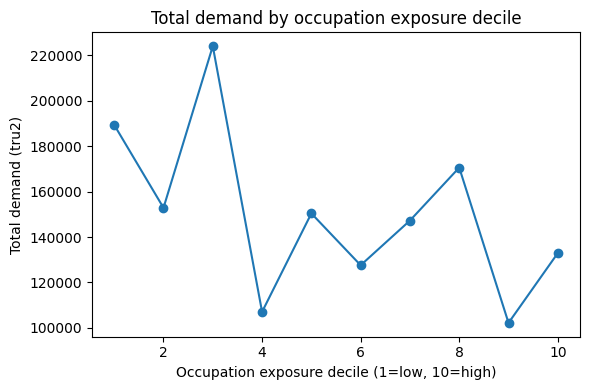

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_total_demand_by_decile.png


In [406]:
# Deciles on occupation exposure (unweighted) - tru2 only

# Use the same DataFrame as the cell above for consistency
# Assume 'occ_nonmiss' is already created from the previous cell

occ_dec2 = occ_nonmiss.groupby("occ_decile").agg(
    demand_tru2=("srvy_wght_tru2", "sum"),
).reset_index()

plt.figure(figsize=(6,4))
plt.plot(occ_dec2["occ_decile"], occ_dec2["demand_tru2"], marker='o')
plt.xlabel("Occupation exposure decile (1=low, 10=high)")
plt.ylabel("Total demand (tru2)")
plt.title("Total demand by occupation exposure decile")
plt.tight_layout()
fig_path2 = OUT_VIS / "fig_total_demand_by_decile.png"
plt.savefig(fig_path2, dpi=150)
plt.show()
print("Saved", fig_path2)





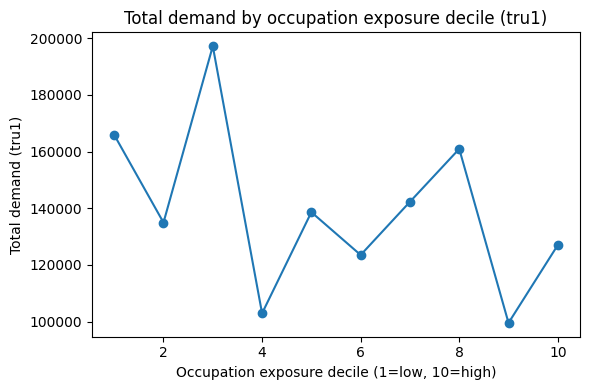

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_total_demand_by_decile_tru1.png


In [407]:
# Deciles on occupation exposure (unweighted) - tru1 only

# Use the same DataFrame as the cell above for consistency
# Assume 'occ_nonmiss' is already created from the previous cell

occ_dec3 = occ_nonmiss.groupby("occ_decile").agg(
    demand_tru1=("srvy_wght_tru1", "sum"),
).reset_index()

plt.figure(figsize=(6,4))
plt.plot(occ_dec3["occ_decile"], occ_dec3["demand_tru1"], marker='o')
plt.xlabel("Occupation exposure decile (1=low, 10=high)")
plt.ylabel("Total demand (tru1)")
plt.title("Total demand by occupation exposure decile (tru1)")
plt.tight_layout()
fig_path3 = OUT_VIS / "fig_total_demand_by_decile_tru1.png"
plt.savefig(fig_path3, dpi=150)
plt.show()
print("Saved", fig_path3)


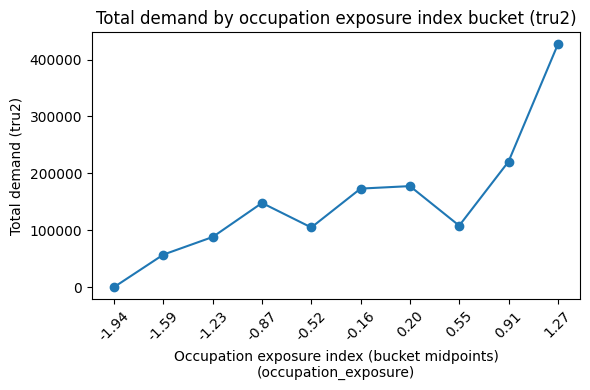

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_total_demand_by_exposure_bucket_tru2_scale.png


In [408]:
# Plot total demand (tru2) vs. true occupation exposure index using "occupation_exposure" and bucket along its real scale
import numpy as np

exposure_col = "occupation_exposure"
if exposure_col not in occ_nonmiss.columns:
    print(
        f"Could not find occupation exposure index column in occ_nonmiss.\n"
        f"Expected column: '{exposure_col}'\n"
        f"Available columns: {list(occ_nonmiss.columns)}"
    )
else:
    num_buckets = 10
    min_exp = occ_nonmiss[exposure_col].min()
    max_exp = occ_nonmiss[exposure_col].max()
    bucket_edges = np.linspace(min_exp, max_exp, num_buckets + 1)

    # Bin into intervals (show bucket as NaN if exposure is missing)
    occ_nonmiss["occ_exp_bucket"] = pd.cut(
        occ_nonmiss[exposure_col],
        bins=bucket_edges,
        labels=False,
        include_lowest=True
    )

    # Compute midpoint of each bucket for x-axis
    bucket_mids = (bucket_edges[:-1] + bucket_edges[1:]) / 2

    # Aggregate tru2 demand per bucket
    bucket_demand = (
        occ_nonmiss.groupby("occ_exp_bucket")
        .agg(demand_tru2=("srvy_wght_tru2", "sum"))
        .reset_index()
    )

    # Attach exposure-value midpoints for x-axis labeling
    bucket_demand["exposure_mid"] = bucket_demand["occ_exp_bucket"].map(
        lambda i: bucket_mids[int(i)] if not np.isnan(i) and int(i) < len(bucket_mids) else np.nan
    )

    plt.figure(figsize=(6,4))
    plt.plot(bucket_demand["exposure_mid"], bucket_demand["demand_tru2"], marker='o')
    plt.xlabel(f"Occupation exposure index (bucket midpoints)\n({exposure_col})")
    plt.ylabel("Total demand (tru2)")
    plt.title("Total demand by occupation exposure index bucket (tru2)")
    # Custom x-ticks at midpoints with proper precision
    plt.xticks(bucket_mids, [f"{m:.2f}" for m in bucket_mids], rotation=45)
    plt.tight_layout()
    fig_path4 = OUT_VIS / "fig_total_demand_by_exposure_bucket_tru2_scale.png"
    plt.savefig(fig_path4, dpi=150)
    plt.show()
    print("Saved", fig_path4)









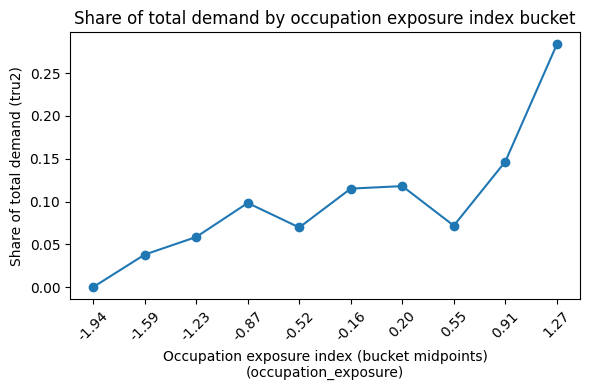

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_share_total_demand_by_exposure_bucket_tru2.png


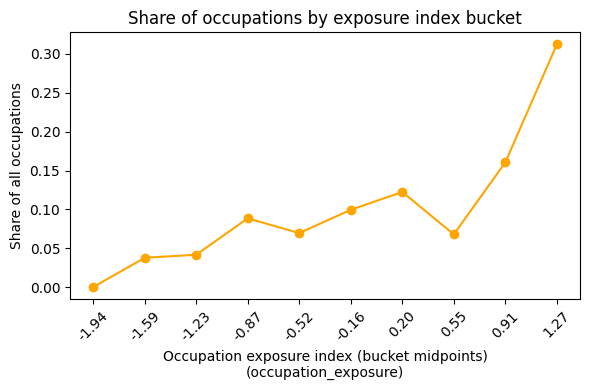

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_share_occupations_by_exposure_bucket.png


In [409]:
# 1. Plot: y = share of total tru2 per exposure bucket (use same binning as before)
bucket_total_tru2 = bucket_demand["demand_tru2"].sum()
bucket_demand["share_of_tru2"] = bucket_demand["demand_tru2"] / bucket_total_tru2

plt.figure(figsize=(6,4))
plt.plot(bucket_demand["exposure_mid"], bucket_demand["share_of_tru2"], marker='o')
plt.xlabel(f"Occupation exposure index (bucket midpoints)\n({exposure_col})")
plt.ylabel("Share of total demand (tru2)")
plt.title("Share of total demand by occupation exposure index bucket")
plt.xticks(bucket_mids, [f"{m:.2f}" for m in bucket_mids], rotation=45)
plt.tight_layout()
fig_path4b = OUT_VIS / "fig_share_total_demand_by_exposure_bucket_tru2.png"
plt.savefig(fig_path4b, dpi=150)
plt.show()
print("Saved", fig_path4b)

# 2. Do the same plot, but with raw count of occupations in each bucket
bucket_demand_count = (
    occ_nonmiss.groupby("occ_exp_bucket")
    .size()
    .reset_index(name="count_occupations")
)
bucket_demand_count["exposure_mid"] = bucket_demand_count["occ_exp_bucket"].map(
    lambda i: bucket_mids[int(i)] if not np.isnan(i) and int(i) < len(bucket_mids) else np.nan
)
total_occupations = bucket_demand_count["count_occupations"].sum()
bucket_demand_count["share_of_occupations"] = bucket_demand_count["count_occupations"] / total_occupations

plt.figure(figsize=(6,4))
plt.plot(bucket_demand_count["exposure_mid"], bucket_demand_count["share_of_occupations"], marker='o', color="orange")
plt.xlabel(f"Occupation exposure index (bucket midpoints)\n({exposure_col})")
plt.ylabel("Share of all occupations")
plt.title("Share of occupations by exposure index bucket")
plt.xticks(bucket_mids, [f"{m:.2f}" for m in bucket_mids], rotation=45)
plt.tight_layout()
fig_path4c = OUT_VIS / "fig_share_occupations_by_exposure_bucket.png"
plt.savefig(fig_path4c, dpi=150)
plt.show()
print("Saved", fig_path4c)



/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/1380710981.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({
/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/1380710981.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


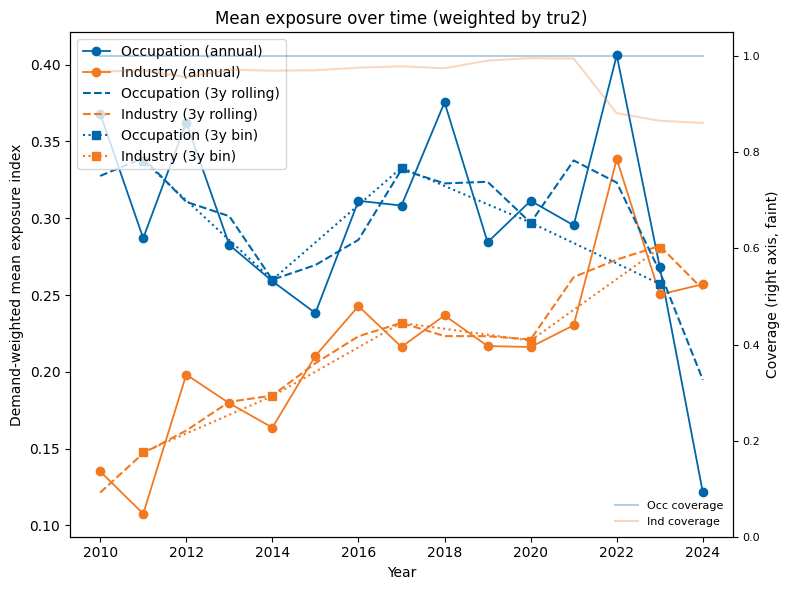

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_mean_exposure_over_time_tru2.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/1380710981.py:151: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc="lower right", fontsize=8, frameon=False)


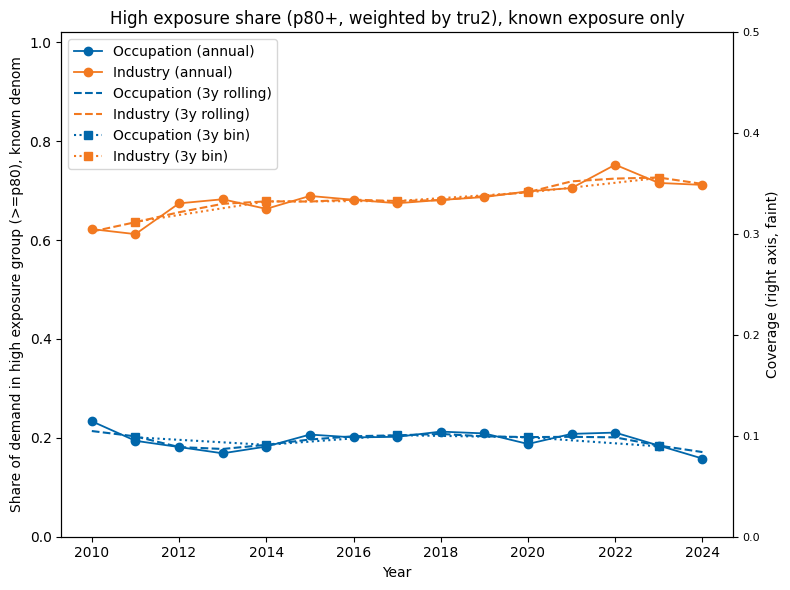

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_high_exposure_share_over_time_tru2.png


In [410]:
import pandas as pd

# Define parameters
YEARS = range(2010, 2025)
OCC_EXP_COL = exposure_col  # e.g., 'occupation_exposure'
IND_EXP_COL = "industry_exposure_weighted"
WEIGHT_COL = "srvy_wght_tru2"
YEAR_COL = "adve_time_year"

# ## ---- PATCH: HARDCODE P80 THRESHOLDS HERE ----
# These values were printed in prior context (cell output 3):
# occ_p80: 1.2383682999999999
# ind_p80: -0.11150409999999998
occ_p80 = 1.2383682999999999
ind_p80 = -0.11150409999999998

# Helper: for 3-year bins
def assign_bin(year, binwidth=3):
    return year - (year - YEARS[0]) % binwidth

# 1. Prepare reduced dataframe (in case not already filtered)
df_ = occ_nonmiss.copy()
df_ = df_[(df_[YEAR_COL] >= min(YEARS)) & (df_[YEAR_COL] <= max(YEARS))]

# 2. Metrics computations ----------

def demand_wmean(x, val, wgt):
    weights = x[wgt][x[val].notna()]
    values = x[val][x[val].notna()]
    return (weights * values).sum() / weights.sum() if not weights.empty else np.nan

def demand_high_share(x, val, wgt, pthresh):
    mask = x[val].notna()
    if mask.sum() == 0:
        return np.nan
    numer = x[wgt][mask & (x[val] >= pthresh)].sum()
    denom = x[wgt][mask].sum()
    return numer / denom if denom > 0 else np.nan

def demand_coverage(x, val, wgt):
    numer = x[wgt][x[val].notna()].sum()
    denom = x[wgt].sum()
    return numer / denom if denom > 0 else np.nan

# 2.1 Annual metrics

annual = (
    df_
    .groupby(YEAR_COL)
    .apply(lambda x: pd.Series({
        "wmean_occ_exp": demand_wmean(x, OCC_EXP_COL, WEIGHT_COL),
        "wmean_ind_exp": demand_wmean(x, IND_EXP_COL, WEIGHT_COL),
        "high_share_occ": demand_high_share(x, OCC_EXP_COL, WEIGHT_COL, occ_p80),
        "high_share_ind": demand_high_share(x, IND_EXP_COL, WEIGHT_COL, ind_p80),
        "coverage_occ": demand_coverage(x, OCC_EXP_COL, WEIGHT_COL),
        "coverage_ind": demand_coverage(x, IND_EXP_COL, WEIGHT_COL),
    }))
    .reset_index()
)

# 2.2 3-year rolling mean (centered)
annual_rolling = annual.set_index(YEAR_COL).rolling(window=3, center=True, min_periods=1).mean().reset_index()
annual_rolling["bin3y"] = annual_rolling[YEAR_COL]  # Convenient for plotting

# 2.3 3-year bins (use bin midpoint)
df_["bin3y"] = df_[YEAR_COL].apply(assign_bin)
bin_groups = (
    df_
    .groupby("bin3y")
    .apply(lambda x: pd.Series({
        "wmean_occ_exp": demand_wmean(x, OCC_EXP_COL, WEIGHT_COL),
        "wmean_ind_exp": demand_wmean(x, IND_EXP_COL, WEIGHT_COL),
        "high_share_occ": demand_high_share(x, OCC_EXP_COL, WEIGHT_COL, occ_p80),
        "high_share_ind": demand_high_share(x, IND_EXP_COL, WEIGHT_COL, ind_p80),
        "coverage_occ": demand_coverage(x, OCC_EXP_COL, WEIGHT_COL),
        "coverage_ind": demand_coverage(x, IND_EXP_COL, WEIGHT_COL),
    }))
    .reset_index()
)
bin_groups["bin3y_mid"] = bin_groups["bin3y"] + 1  # For x-axis label (midpoint of 3 years)

# 3. PLOTS ================

import matplotlib.pyplot as plt

colors = {"occ": "#0066AA", "ind": "#F27920"}

### A) Mean exposure over time (tru2) - two lines

plt.figure(figsize=(8,6))
# Annual
plt.plot(annual[YEAR_COL], annual["wmean_occ_exp"], label="Occupation (annual)", color=colors["occ"], marker="o", lw=1.3)
plt.plot(annual[YEAR_COL], annual["wmean_ind_exp"], label="Industry (annual)", color=colors["ind"], marker="o", lw=1.3)

# Rolling
plt.plot(annual_rolling[YEAR_COL], annual_rolling["wmean_occ_exp"], label="Occupation (3y rolling)", color=colors["occ"], linestyle="--")
plt.plot(annual_rolling[YEAR_COL], annual_rolling["wmean_ind_exp"], label="Industry (3y rolling)", color=colors["ind"], linestyle="--")

# Binned
plt.plot(bin_groups["bin3y_mid"], bin_groups["wmean_occ_exp"], label="Occupation (3y bin)", color=colors["occ"], marker="s", linestyle=":")
plt.plot(bin_groups["bin3y_mid"], bin_groups["wmean_ind_exp"], label="Industry (3y bin)", color=colors["ind"], marker="s", linestyle=":")

plt.xlabel("Year")
plt.ylabel("Demand-weighted mean exposure index")
plt.title("Mean exposure over time (weighted by tru2)")
plt.xticks(list(YEARS)[::2])
plt.legend(loc="upper left")

# Plot coverage as small lines on right axis
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(annual[YEAR_COL], annual["coverage_occ"], color=colors["occ"], ls="-", alpha=0.3, label="Occ coverage")
ax2.plot(annual[YEAR_COL], annual["coverage_ind"], color=colors["ind"], ls="-", alpha=0.3, label="Ind coverage")
ax2.set_ylabel("Coverage (right axis, faint)")
ax2.set_ylim(0, 1.05)
ax2.tick_params(axis='y', labelsize=8)
ax2.legend(loc="lower right", fontsize=8, frameon=False)
plt.tight_layout()
fig_meanexp_path = OUT_VIS / "fig_mean_exposure_over_time_tru2.png"
plt.savefig(fig_meanexp_path, dpi=150)
plt.show()
print("Saved", fig_meanexp_path)

### B) High-exposure share (p80, known denom, tru2) - two lines

plt.figure(figsize=(8,6))
plt.plot(annual[YEAR_COL], annual["high_share_occ"], label="Occupation (annual)", color=colors["occ"], marker="o", lw=1.3)
plt.plot(annual[YEAR_COL], annual["high_share_ind"], label="Industry (annual)", color=colors["ind"], marker="o", lw=1.3)

plt.plot(annual_rolling[YEAR_COL], annual_rolling["high_share_occ"], label="Occupation (3y rolling)", color=colors["occ"], linestyle="--")
plt.plot(annual_rolling[YEAR_COL], annual_rolling["high_share_ind"], label="Industry (3y rolling)", color=colors["ind"], linestyle="--")

plt.plot(bin_groups["bin3y_mid"], bin_groups["high_share_occ"], label="Occupation (3y bin)", color=colors["occ"], marker="s", linestyle=":")
plt.plot(bin_groups["bin3y_mid"], bin_groups["high_share_ind"], label="Industry (3y bin)", color=colors["ind"], marker="s", linestyle=":")

plt.xlabel("Year")
plt.ylabel("Share of demand in high exposure group (>=p80), known denom")
plt.title("High exposure share (p80+, weighted by tru2), known exposure only")
plt.ylim(0, 1.02)
plt.xticks(list(YEARS)[::2])
plt.legend(loc="upper left")

# Plot coverage
ax1 = plt.gca()
ax2 = ax1.twinx()
#ax2.plot(annual[YEAR_COL], annual["coverage_occ"], color=colors["occ"], ls="-", alpha=0.3, label="Occ coverage")
#ax2.plot(annual[YEAR_COL], annual["coverage_ind"], color=colors["ind"], ls="-", alpha=0.3, label="Ind coverage")
ax2.set_ylabel("Coverage (right axis, faint)")
ax2.set_ylim(0, 0.5)
ax2.tick_params(axis='y', labelsize=8)
ax2.legend(loc="lower right", fontsize=8, frameon=False)
plt.tight_layout()
fig_highshare_path = OUT_VIS / "fig_high_exposure_share_over_time_tru2.png"
plt.savefig(fig_highshare_path, dpi=150)
plt.show()
print("Saved", fig_highshare_path)




Columns available in 'annual': ['adve_time_year', 'wmean_occ_exp', 'wmean_ind_exp', 'high_share_occ', 'high_share_ind', 'coverage_occ', 'coverage_ind']


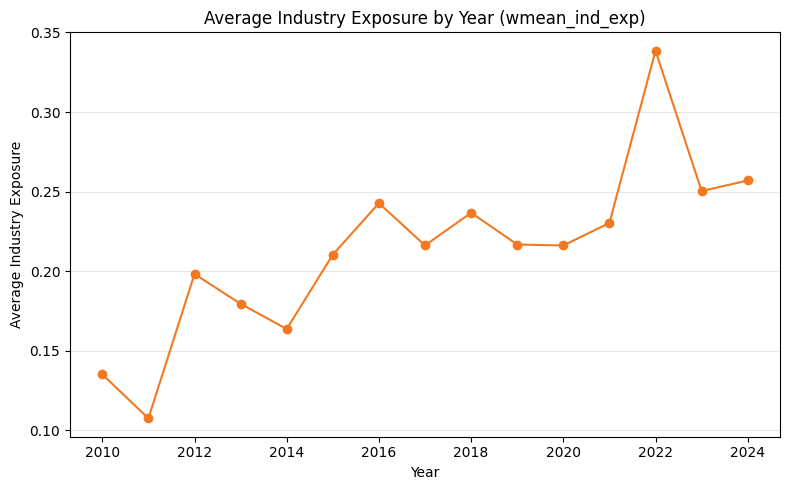

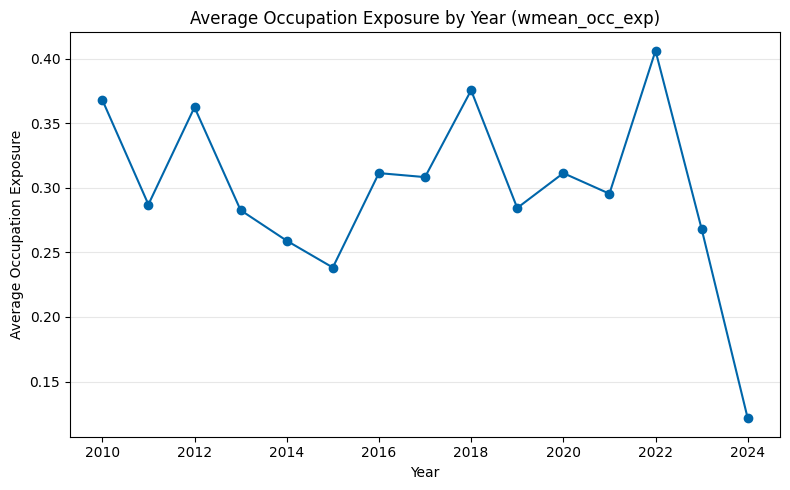

In [411]:
# It appears the columns 'mean_ind_exp_tru2', 'mean_occ_exp_tru2', and 'ind_exp_tru2' do not exist in annual.
# The mean exposure series may instead already be calculated in annual as 'mean_ind_exp' and 'mean_occ_exp' or similar.
# Let's inspect annual.columns and plot any mean exposure columns per year.
# If such columns do not exist, we will skip plotting and display an informative message.

print("Columns available in 'annual':", list(annual.columns))

# Try to infer column names for mean exposures
mean_ind_col = None
mean_occ_col = None
for c in annual.columns:
    cl = c.lower()
    if "mean" in cl and ("ind" in cl or "industry" in cl) and ("tru2" in cl or True):
        mean_ind_col = c
    if "mean" in cl and ("occ" in cl or "occupation" in cl) and ("tru2" in cl or True):
        mean_occ_col = c

if mean_ind_col is not None:
    plt.figure(figsize=(8, 5))
    plt.plot(annual[YEAR_COL], annual[mean_ind_col], color=colors["ind"], marker="o", lw=1.5)
    plt.xlabel("Year")
    plt.ylabel("Average Industry Exposure")
    plt.title(f"Average Industry Exposure by Year ({mean_ind_col})")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No column found for mean industry exposure in 'annual'.")

if mean_occ_col is not None:
    plt.figure(figsize=(8, 5))
    plt.plot(annual[YEAR_COL], annual[mean_occ_col], color=colors["occ"], marker="o", lw=1.5)
    plt.xlabel("Year")
    plt.ylabel("Average Occupation Exposure")
    plt.title(f"Average Occupation Exposure by Year ({mean_occ_col})")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No column found for mean occupation exposure in 'annual'.")




